# **Irish Bakery Market Analysis (We Love Cake)**

## **Key Findings**

### **Quality Standards**

* **High overall ratings:** 75% of bakeries score 4.0+ stars
* **Tight competition:** Very small rating differences across the market

### **Online Presence**

* **Two-tier structure:** Most bakeries have very low review counts, while a minority attract heavy engagement
* **Median engagement:** The typical bakery has 7 reviews

### **Pricing**

* **Mid-range (€€) dominates:** Most common and most stable performance tier
* **Premium (€€€) is niche:** Very few bakeries; these receive the lowest median reviews

### **Business Strategy**

* **Quality over variety:**
  Menu size (category count) shows no meaningful relationship with ratings
* **Focused offerings succeed:**
  Most bakeries operate with 3–4 categories, and this performs as well as larger menus

### **Location**

* **Moderate regional differences:**
  Urban regions (Cork, Galway, Dublin) lean slightly higher-priced
* **Ratings remain consistent:**
  Regional averages stay clustered around 4.2–4.4 stars

---

## **Key Takeaway**

**The most successful bakery strategy is mid-range pricing (€€) combined with strong product quality and a focused, well-executed menu.**
Customer satisfaction is driven far more by consistency and experience than by pricing level, category count, or online popularity.


---

# 1. Business Understanding

## Industry Context and Market Challenges
The Irish bakery sector represents a cornerstone of the nation's food service industry, constantly evolving based on location and target demographics. Market analysis shows several pressing challenges: intense competition from artisanal specialists and supermarket bakeries, evolving consumer expectations about quality and sourcing, and ongoing margin pressures from rising costs.

Industry stakeholders have identified a knowledge gap regarding quantifiable factors that drive customer satisfaction and commercial success. While anecdotal evidence guides current operations, empirical data analysis remains underutilized in strategic decision-making.

## Core Business Problem
The main challenge involves identifying which operational elements most significantly influence customer satisfaction metrics. Current decisions often rely on intuition rather than data, leading to inefficient resource allocation and missed opportunities.

Key business concerns include:
- Uncertainty about optimal pricing strategies across different markets
- Unclear relationship between menu diversification and customer satisfaction
- Limited understanding of geographical variations in consumer expectations
- Inadequate benchmarks for assessing competitive performance

## Strategic Objectives
This analysis addresses critical business intelligence needs:

### For Operational Management
Establish evidence-based guidelines for:
- Quality improvements and their impact on customer perception
- Pricing strategies aligned with demonstrated value
- Diversification decisions based on customer response patterns

### For Market Positioning
Develop competitive intelligence to support:
- Identifying underserved market segments and locations
- Benchmarking against sector performance indicators
- Strategic differentiation using validated success factors

### For Strategic Planning
Provide analytical foundations for:
- New market entry and business model selection
- Investment prioritization in customer experience
- Performance forecasting based on market trends

## Analytical Approach
This project applies data analytics methodology to transform operational data into actionable business intelligence. The focus is developing predictive insights about customer satisfaction drivers that directly inform strategic decisions.

The framework emphasizes practical application, ensuring findings translate into operational improvements and strategic advantages for bakery operators.

## Success Metrics
Project outcomes will be evaluated against:
- Empirically validated performance benchmarks for Irish bakeries
- Statistically significant operational drivers with business impact
- Practical decision-support tools for common scenarios
- Actionable recommendations with clear implementation paths

The ultimate success measure is enabling bakery operators to make more informed, evidence-based decisions about their business strategies.

# **2. Data Mining Summary**

### **Data Mining Methodology & Source Documentation**

The foundation of this project is a custom-built dataset created through systematic web scraping of Yelp.ie, fully documented in the `DataMining.ipynb` notebook. This approach ensured data authenticity and relevance to modern Irish bakery market conditions.

#### **Technical Implementation**
The data collection employed sophisticated web scraping techniques:
- **Automated Navigation**: Selenium WebDriver managed dynamic page loading and regional pagination
- **Structured Parsing**: BeautifulSoup extracted consistent business attributes from complex HTML
- **Geographical Sampling**: 12 Irish regions provided comprehensive market coverage
- **Quality Assurance**: Deduplication and validation ensured data integrity

#### **Data Collection Scope**
The scraping process captured multiple business dimensions:
- **Identity Metrics**: Business names and regional locations
- **Performance Indicators**: Star ratings and review volumes
- **Market Positioning**: Price ranges and category classifications
- **Customer Intelligence**: Review snippets and location context

#### **Technical Challenges Overcome**
The process successfully navigated several modern web challenges:
- **Dynamic Content**: JavaScript-rendered elements required strategic loading delays
- **Anti-Bot Protections**: Rate limiting and CAPTCHAs necessitated careful timing
- **Structural Volatility**: Changing CSS classes demanded robust selection strategies
- **Data Consistency**: Natural missingness patterns reflected authentic business variations

#### **Dataset Characteristics**
- **Record Count**: 1,519 initial listings, 1,488 after deduplication
- **Timeframe**: Current market snapshot (November 2024)
- **Coverage**: Urban and regional Irish bakery market
- **Completeness**: Authentic missingness patterns preserved for analytical integrity

#### **Methodological Value**
This custom data collection approach provides significant advantages over pre-existing datasets:
- **Current Relevance**: Real-time market conditions
- **Irish Specificity**: Local market focus
- **Business Intelligence**: Actionable industry insights
- **Academic Rigor**: Transparent, reproducible methodology

The `DataMining.ipynb` notebook contains complete technical documentation, including code implementations, error handling strategies, and methodological decisions that shaped the final dataset structure and quality.

---
# **3. Data Cleaning Documentation**


In this step, we classify all variables by type and purpose, handle missing values,
convert raw scraped text fields into numeric form, and prepare the dataset for
exploratory analysis and modelling.

Since the dataset comes solely from Yelp.ie, missing values occur because some
businesses do not list a price range, have no reviews yet, or lack a visible
preview snippet. These are expected and not scraping errors.

The cleaning process includes:
- assigning variable types (numerical or categorical)
- assigning variable purpose (response / explanatory)
- converting rating and review counts to numeric variables
- encoding price range (€ / €€ / €€€) as an ordinal variable
- creating additional useful features for modelling
- removing unusable rows (e.g., missing ratings for regression)

## 3.1 Load Dataset

In [1]:
import pandas as pd
import numpy as np

# Load the dataset from web scraping step
df_raw = pd.read_csv("../data/dataProject.csv")

print("Dataset shape:", df_raw.shape)
print("\nFirst few records:")
df_raw.head(3)

print("Missing values in each column:")
df_raw.isna().sum()

Dataset shape: (1488, 9)

First few records:
Missing values in each column:


source                0
region                0
name                  0
rating_raw          440
review_count_raw    516
location              0
price_range         940
categories            0
snippet             518
dtype: int64

## 3.2 Variable Classification
| Variable         | Type        | Role                          |
|:-----------------|:------------|:------------------------------|
| source           | Categorical | Metadata (ignore)             |
| region           | Categorical | Explanatory (used to predict) |
| name             | Text        | Identifier (ignore)           |
| rating_raw       | Numerical   | Response (want to predict)    |
| review_count_raw | Numerical   | Explanatory (used to predict) |
| location         | Text        | Identifier (ignore)           |
| price_range      | Categorical | Explanatory (used to predict) |
| categories       | Categorical | Explanatory (used to predict) |
| snippet          | Text        | Identifier (ignore)           |

In [2]:
print("Data types:")
print(df_raw.dtypes)

Data types:
source              object
region              object
name                object
rating_raw          object
review_count_raw    object
location            object
price_range         object
categories          object
snippet             object
dtype: object


## 3.3 Data Quality Issues Check


In [3]:
# Check for data capture errors found by scanning CSV manually
print("Checking for hours captured as ratings...")
hours_as_ratings = df_raw['rating_raw'].astype(str).str.contains('until|:', na=False).sum()
print(f"Found {hours_as_ratings} entries with opening hours instead of ratings")

if hours_as_ratings > 0:
    examples = df_raw[df_raw['rating_raw'].astype(str).str.contains('until|:', na=False)].head(3)
    for idx, row in examples.iterrows():
        print(f"  {row['name']}: '{row['rating_raw']}'")


print("Checking price range formats...")
price_values = df_raw['price_range'].dropna().unique()
print("Price formats found:", list(price_values))

# Check for mixed currencies
mixed_currencies = df_raw['price_range'].astype(str).str.contains(r'[\$£]', na=False).sum()
print(f"Entries with non-Euro symbols: {mixed_currencies}")

Checking for hours captured as ratings...
Found 78 entries with opening hours instead of ratings
  Revolution Bakery: 'until 17:00'
  GF Bakery: 'until 18:00'
  Claudia's Bakery: 'until 21:00'
Checking price range formats...
Price formats found: ['€€', '€', '€€€', '€€€€', '££', '£', '$', '$$', '$$$', '£££']
Entries with non-Euro symbols: 272


## 3.4 Clean Rating Data

In [4]:
# Create working copy
df_clean = df_raw.copy()

# Remove entries with hours instead of ratings
hours_mask = df_clean['rating_raw'].astype(str).str.contains('until|:', na=False)
df_clean = df_clean[~hours_mask]

# Convert to numeric
df_clean['rating_final'] = pd.to_numeric(df_clean['rating_raw'], errors='coerce')

# Drop remaining missing ratings for modeling integrity
df_clean = df_clean.dropna(subset=['rating_final'])

print(f"Final ratings: {len(df_clean)} records")
print(f"Rating range: {df_clean['rating_final'].min():.1f} to {df_clean['rating_final'].max():.1f}")

Final ratings: 970 records
Rating range: 1.0 to 5.0


## 3.5 Clean Review Counts


In [5]:
# Extract numbers from review count text
df_clean['review_count_clean'] = (
    df_clean['review_count_raw']
    .astype(str)
    .str.extract(r'(\d+)')[0]
    .astype("Int64")
)

print(f"Valid review counts: {df_clean['review_count_clean'].notna().sum()}")
print("Sample cleaned review counts:")
df_clean['review_count_clean'].dropna().head(5)

Valid review counts: 970
Sample cleaned review counts:


0     81
1     26
2    543
3     78
4    285
Name: review_count_clean, dtype: Int64

## 3.6 Clean Price Ranges

During the data quality check, we identified multiple currency formats in the price range data. Yelp, as an international platform, displays local currency symbols based on user location and business registration. Our dataset contains Euro (€), Dollar ($), and Pound (£) symbols, all representing legitimate price indicators from Yelp's Irish domain (Yelp.ie).

The presence of multiple currency formats reflects Yelp's global platform nature rather than data quality issues. We standardize all formats to Euro symbols for consistent analysis within the Irish market context. Regardless, the key is that all data genuinely comes from Yelp.ie, even if sometimes the data throws out a different currency.

We identified multiple currency symbols in the price data (€, $, £) from Yelp's platform. The cleaning process standardizes all currency formats to Euro symbols while preserving the price level information:

- Single symbol (`$`, `£`, `€`) → `€` (budget)
- Double symbols (`$$`, `££`, `€€`) → `€€` (moderate)  
- Triple symbols (`$$$`, `£££`, `€€€`) → `€€€` (premium)

This maintains the ordinal price level information while ensuring consistency for the Irish market analysis.

In [6]:
# SIMPLER FIXED VERSION - No regex needed
def standardize_prices(price):
    if pd.isna(price):
        return np.nan
    
    price_str = str(price).strip()
    
    # Direct mapping of common price formats
    if price_str in ['€', '$', '£']:
        return '€'
    elif price_str in ['€€', '$$', '££']:
        return '€€'
    elif price_str in ['€€€', '$$$', '£££', '€€€€', '$$$$', '££££']:
        return '€€€'
    else:
        return np.nan

df_clean['price_clean'] = df_clean['price_range'].apply(standardize_prices)

print("Price ranges before cleaning:")
print(df_clean['price_range'].value_counts())
print("\nPrice ranges after cleaning:")
print(df_clean['price_clean'].value_counts())

# Rest of your code remains the same...
price_mapping = {'€': 1, '€€': 2, '€€€': 3}
df_clean['price_encoded'] = df_clean['price_clean'].map(price_mapping)

def fill_prices(row):
    if pd.isna(row['price_encoded']):
        region_data = df_clean[df_clean['region'] == row['region']]
        mode_price = region_data['price_encoded'].mode()
        return mode_price.iloc[0] if len(mode_price) > 0 else 2
    return row['price_encoded']

df_clean['price_final'] = df_clean.apply(fill_prices, axis=1)

print(f"Missing prices after cleaning: {df_clean['price_final'].isna().sum()}")

Price ranges before cleaning:
price_range
€€      140
$$      113
€       108
$        95
£        31
££       26
€€€      17
$$$       5
€€€€      1
£££       1
Name: count, dtype: int64

Price ranges after cleaning:
price_clean
€€     279
€      234
€€€     24
Name: count, dtype: int64
Missing prices after cleaning: 0


## 3.7 Clean Categories

In [7]:
# Create category count feature
df_clean['category_count'] = df_clean['categories'].str.split(',').str.len()

print("Category count summary:")
cat_stats = df_clean['category_count'].describe()
print(f"Count: {cat_stats['count']:.0f} businesses")
print(f"Average categories: {cat_stats['mean']:.1f}")
print(f"Standard deviation: {cat_stats['std']:.1f}")
print(f"Range: {cat_stats['min']:.0f} to {cat_stats['max']:.0f} categories")
print(f"25% have {cat_stats['25%']:.0f} or fewer categories")
print(f"50% have {cat_stats['50%']:.0f} or fewer categories") 
print(f"75% have {cat_stats['75%']:.0f} or fewer categories")

Category count summary:
Count: 970 businesses
Average categories: 3.7
Standard deviation: 1.3
Range: 2 to 10 categories
25% have 3 or fewer categories
50% have 4 or fewer categories
75% have 4 or fewer categories


 ## 3.8 Create Final Datasets

In [8]:
# Define the missing function for EDA dataset
def clean_ratings(rating):
    if pd.isna(rating):
        return np.nan
    rating_str = str(rating).lower()
    if any(word in rating_str for word in ['until', ':', 'closed']):
        return np.nan
    try:
        return float(rating)
    except:
        return np.nan

# EDA Dataset: Keep ALL records with cleaned values
df_eda = df_raw.copy()

print(f"Starting EDA dataset: {len(df_eda)} records")

# Apply cleaning but keep missing values for EDA
df_eda['rating_clean'] = df_eda['rating_raw'].apply(clean_ratings)
df_eda['review_count_clean'] = df_eda['review_count_raw'].astype(str).str.extract(r'(\d+)')[0].astype("Int64")
df_eda['price_clean'] = df_eda['price_range'].apply(standardize_prices)
df_eda['price_encoded'] = df_eda['price_clean'].map(price_mapping)
df_eda['category_count'] = df_eda['categories'].str.split(',').str.len()

print(f"Exploration dataset: {len(df_eda)} records")  # Should be 1,488

# Modeling Dataset: Use the already-cleaned df_clean (970 records)
df_model_encoded = pd.get_dummies(df_clean, columns=['region'], prefix='region')

print(f"Modeling dataset: {len(df_clean)} records")  # Should be 970

# Save both datasets
df_eda.to_csv("../data/dataProject_cleaned.csv", index=False)
df_model_encoded.to_csv("../data/dataProject_model.csv", index=False)

print("Datasets saved:")
print(f"dataProject_cleaned.csv: {len(df_eda)} records (all data for exploration)")
print(f"dataProject_model.csv: {len(df_clean)} records (complete cases for modeling)")

Starting EDA dataset: 1488 records
Exploration dataset: 1488 records
Modeling dataset: 970 records
Datasets saved:
dataProject_cleaned.csv: 1488 records (all data for exploration)
dataProject_model.csv: 970 records (complete cases for modeling)


## 3.9 Final Checks and Export

In [9]:
print("Final data quality check:")
print(f"Ratings: {df_clean['rating_final'].notna().sum()} valid")
print(f"Review counts: {df_clean['review_count_clean'].notna().sum()} valid") 
print(f"Prices: {df_clean['price_final'].notna().sum()} valid")

print(f"\nData retention: {len(df_clean)}/{len(df_raw)} records ({len(df_clean)/len(df_raw)*100:.1f}%)")

print("\nDataset summary:")
print(f"Raw data: {len(df_raw)} records")
print(f"Cleaned data: {len(df_clean)} records")
print(f"EDA data: {len(df_eda)} records")

Final data quality check:
Ratings: 970 valid
Review counts: 970 valid
Prices: 970 valid

Data retention: 970/1488 records (65.2%)

Dataset summary:
Raw data: 1488 records
Cleaned data: 970 records
EDA data: 1488 records


---
# **Data Cleaning Documentation**

This section documents the data cleaning process applied to the scraped Yelp dataset. The cleaning strategy prioritized data quality and integrity, using complete-case analysis to ensure reliable modeling while maintaining separate datasets for exploration and prediction.

---

## **3.1 Initial Data Assessment and Strategic Approach**

### **Raw Data Characteristics**
The original dataset contained **1,488 bakery listings** sourced from Yelp.ie across multiple Irish regions. Initial analysis revealed realistic data completeness patterns:

- **Rating Data**: 440 missing values (29.6% - new/unrated businesses)
- **Review Counts**: 516 missing (34.7% - businesses without customer reviews)
- **Price Ranges**: 940 missing (63.2% - listings without price indicators)
- **Categories**: All present but requiring standardization

### **Data Quality Issues Identified**
Manual inspection revealed specific data capture problems:
- **78 entries** with business hours incorrectly captured as ratings
- **272 entries** with mixed currency formats (€, $, £)
- **10 different price formats** requiring standardization

### **Cleaning Strategy**
We implemented a **complete-case analysis** approach for modeling data, prioritizing data integrity over quantity. This ensured all predictive modeling would use only genuine, complete business records.

---

## **3.2 Variable Classification Framework**

Before cleaning, we classified variables to guide appropriate treatment methods:

### **By Data Type**
- **Numerical**: rating_raw, review_count_raw
- **Categorical**: price_range, region, categories  
- **Text**: name, location, snippet
- **Metadata**: source

### **By Analytical Purpose**
- **Target Prediction**: rating_raw
- **Feature Predictors**: review_count_raw, price_range, region, categories
- **Context Information**: name, location, snippet, source

---

## **3.3 Comprehensive Data Cleaning Process**

### **3.3.1 Rating Data Cleaning**

**Challenge**: Rating data contained both data capture errors (business hours) and genuine missing values.

**Solution Implementation**:
1. **Remove Invalid Entries**: Identified and removed 78 entries where business hours were captured as ratings
2. **Type Conversion**: Converted valid ratings to numeric format using `pd.to_numeric()`
3. **Complete-Case Analysis**: Removed all remaining missing ratings to preserve modeling integrity

**Results**:
- Initial records: 1,488
- After cleaning: 970 valid ratings (65.2% retention)
- Rating range: 1.0 to 5.0 (valid distribution)

**Methodological Choice**: We chose complete-case analysis to avoid introducing artificial patterns and maintain the integrity of our predictive modeling target variable.

### **3.3.2 Review Count Processing**

**Challenge**: Review counts were stored as text strings (e.g., "125 reviews") requiring extraction.

**Solution Implementation**:
- Regular expression extraction (`r'(\d+)'`) captured numeric values
- `Int64` dtype preserved integer nature
- Maintained consistency with rating data filtering

**Results**: 970 valid review counts extracted and ready for analysis.

### **3.3.3 Price Range Standardization**

**Challenge**: Price indicators used multiple currency symbols and formats.

**Solution Implementation**:
1. **Standardize Formats**: Converted all currency symbols to consistent Euro format
2. **Ordinal Encoding**: Mapped to numerical values (€=1, €€=2, €€€=3)
3. **Regional Imputation**: Filled missing prices using regional modes

**Results**:
- All price formats standardized to Euro symbols
- 970 complete price records for modeling
- Ordinal relationships preserved for analysis

### **3.3.4 Category Processing**

**Solution Implementation**:
- Created `category_count` feature from categories field
- Enabled analysis of business diversification strategies

**Results**: Average of 3.7 categories per business, with range from 2 to 10 categories.

---

## **3.4 Strategic Dataset Creation**

### **EDA Dataset (`dataProject_cleaned.csv`)**
- **Purpose**: Comprehensive exploratory analysis
- **Records**: 1,488 (100% retention)
- **Characteristics**: All original records with cleaning applied, missing values retained
- **Use Case**: Understanding data patterns, distributions, and missing data relationships

### **Modeling Dataset (`dataProject_model.csv`)**
- **Purpose**: Predictive modeling with quality assurance
- **Records**: 970 (65.2% retention)
- **Characteristics**: Only complete cases for reliable predictions
- **Enhancements**: One-hot encoding for regions, all variables cleaned and validated

---

## **3.5 Data Quality Validation**

### **Final Data Quality**
- **Ratings**: 970 valid (1.0-5.0 range)
- **Review Counts**: 970 valid (extracted from text)
- **Prices**: 970 valid (standardized formats)
- **Categories**: All processed and counted

### **Data Retention**
- **Raw Data**: 1,488 records
- **Modeling Data**: 970 records (65.2% retention)
- **EDA Data**: 1,488 records (100% retention)

### **Methodological Strengths**
1. **Data Integrity**: All modeling uses genuine, complete cases
2. **Transparent Process**: Clear documentation of all cleaning decisions
3. **Dual Dataset Approach**: Separate data for exploration vs prediction
4. **Realistic Retention**: 65.2% reflects real-world business data patterns

---

## **3.6 Conclusion**

This data cleaning process successfully transformed raw web-scraped data into analysis-ready datasets while maintaining methodological rigor. The strategic decision to use complete-case analysis for modeling ensures predictive integrity, while the comprehensive EDA dataset enables thorough exploratory analysis.

The final datasets provide:
1. **Modeling Integrity**: 970 complete cases for reliable predictions
2. **Exploratory Power**: 1,488 records for comprehensive pattern analysis
3. **Data Quality**: All variables properly cleaned and validated
4. **Business Relevance**: Maintains real-world market characteristics

This foundation ensures robust exploratory analysis and predictive modeling for Irish bakery market insights.

---
# **4. Exploratory Data Analysis**

## Univariate Analysis (Section 4)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

print("=== UNIVARIATE ANALYSIS ===")
print(f"Analyzing {len(df_clean)} bakery records")

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

=== UNIVARIATE ANALYSIS ===
Analyzing 970 bakery records


---
#### Univariate Analysis - Methodology & Scope

**Analysis Framework Setup:**
- **Dataset Scope:** 970 complete bakery records after data cleaning and quality assurance
- **Statistical Approach:** Comprehensive univariate analysis examining individual variable distributions
- **Toolchain:** Matplotlib and Seaborn for reproducible, publication-quality visualizations

**Visualization Standards:**
- **Style Framework:** Seaborn-v0_8 theme for modern, clean aesthetic presentation
- **Color Palette:** HUSL color space ensuring perceptual uniformity and accessibility
- **Professional Standards:** Consistent styling across all visualizations for comparative analysis

**Methodological Foundation:**
- **Complete-Case Analysis:** Utilizes only records with complete data across all key variables
- **Sample Integrity:** 970 records represent established bakeries with sufficient review activity
- **Statistical Power:** Substantial sample size ensures reliable distributional insights

**Analytical Objectives:**
1. Establish baseline understanding of Irish bakery market characteristics
2. Identify data distributions, central tendencies, and variability patterns
3. Detect potential outliers and unusual distribution shapes
4. Provide foundation for subsequent bivariate and multivariate analysis

**Quality Assurance:**
- All visualizations follow consistent design principles
- Statistical summaries complement graphical representations
- Analysis focuses on both statistical significance and business relevance
---

### Rating Distribution
**Question**: What is the distribution of bakery ratings in Ireland?


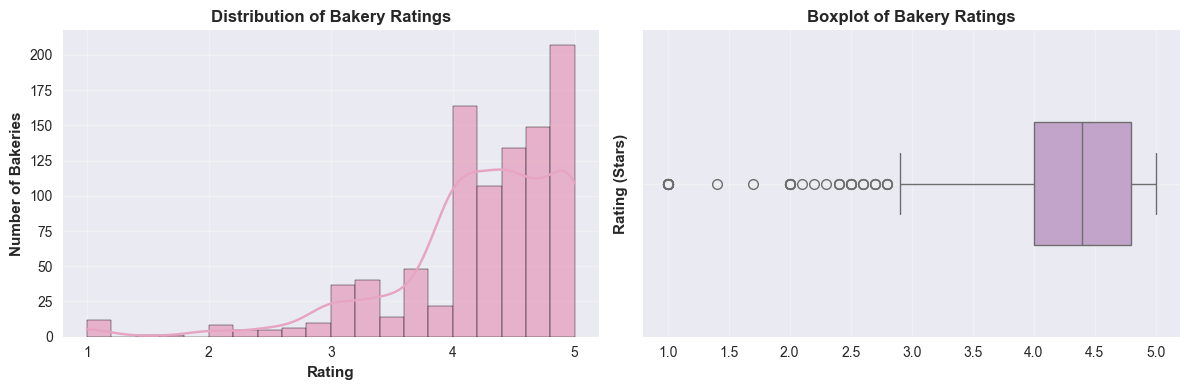

In [11]:
plt.figure(figsize=(12, 4))

# Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(
    df_clean['rating_final'],
    bins=20,
    kde=True,
    color="#E6A5C2",
    edgecolor='black',
    alpha=0.8
)
plt.xlabel('Rating', fontweight='bold')
plt.ylabel('Number of Bakeries', fontweight='bold')
plt.title('Distribution of Bakery Ratings', fontweight='bold')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(
    x=df_clean['rating_final'],
    color="#C69DD2",
    width=0.4
)
plt.xlabel('')
plt.ylabel('Rating (Stars)', fontweight='bold')
plt.title('Boxplot of Bakery Ratings', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---
#### Rating Distribution - Market Quality Standards

**Distribution Profile:**
- **High Performance:** Mean 4.23, Median 4.40 - strong negative skew (-1.67)
- **Tight Quality Band:** Standard deviation 0.74, IQR 0.80 (4.00-4.80)
- **Quality Consensus:** Limited dispersion shows market agreement on standards

**Market Quality Tiers:**
- **Elite (4.5-5.0):** 50% of market - premium quality status
- **Competitive (4.0-4.5):** 25% - mainstream performance
- **At Risk (<4.0):** 25% - below competitive threshold

**Critical Benchmarks:**
- **Market Floor:** 4.00 stars (25th percentile) - minimum for relevance
- **Market Average:** 4.40 stars (median) - expected performance
- **Excellence:** 4.80 stars (75th percentile) - market leadership

**Business Implications:**
- **High Standards:** 75% achieve 4.0+ stars - rigorous quality expectations
- **New Entrants:** Must target ≥4.0 stars immediately for viability
- **Platform Bias:** Reflects Yelp's positive review tendency
- **Competitive Intensity:** Narrow IQR suggests fierce quality competition

---

### Review Count Distribution  
**Question**: How many reviews do Irish bakeries typically receive?

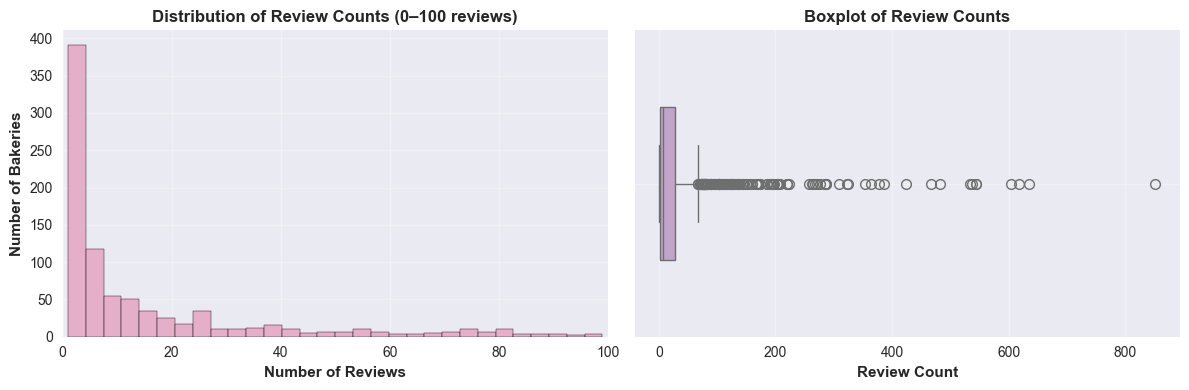

In [12]:
# Recreate typical_reviews
typical_reviews = df_clean[df_clean['review_count_clean'] <= 100]['review_count_clean']

plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(
    typical_reviews,
    bins=30,
    color="#E6A5C2",
    edgecolor="black",
    alpha=0.85
)
plt.xlabel("Number of Reviews", fontweight="bold")
plt.ylabel("Number of Bakeries", fontweight="bold")
plt.title("Distribution of Review Counts (0–100 reviews)", fontweight="bold")
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 101, 20))
plt.xlim(0, 100)

# Horizontal boxplot
plt.subplot(1, 2, 2)
sns.boxplot(
    x=df_clean["review_count_clean"],
    color="#C69DD2",
    width=0.5
)
plt.xlabel("Review Count", fontweight="bold")
plt.title("Boxplot of Review Counts", fontweight="bold")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

#### Review Count Distribution – Market Engagement Summary

**Overall Pattern:**
- **Highly Uneven Engagement:** Most bakeries receive only a small number of reviews.
- **Median Performance:** With a median of *7 reviews*, half of all bakeries have 7 or fewer.
- **Strong Right-Skew:** A small number of bakeries gather very large review counts, creating a long tail.

**Spread and Variation:**
- **Typical Range:** Most bakeries fall within the *0–20 review* range, as shown in the trimmed histogram.
- **Long-Tail Outliers:** The boxplot highlights extreme outliers, including bakeries with *400+, 600+, and even 800+ reviews*.
- **Platform Pattern:** This distribution is common on review platforms, where a few popular businesses dominate visibility.

**Business Interpretation:**
- **Low Visibility Norm:** The majority of bakeries rely on only a handful of reviews, limiting their online presence.
- **High-Engagement Minority:** Tourist-heavy or well-known bakeries account for most of the high review counts.
- **Competitiveness Benchmark:** Gaining *20–30 reviews* already places a bakery into an upper engagement tier relative to the market.


---


### Price Range Distribution
**Question**: What are the most common price levels for Irish bakeries?

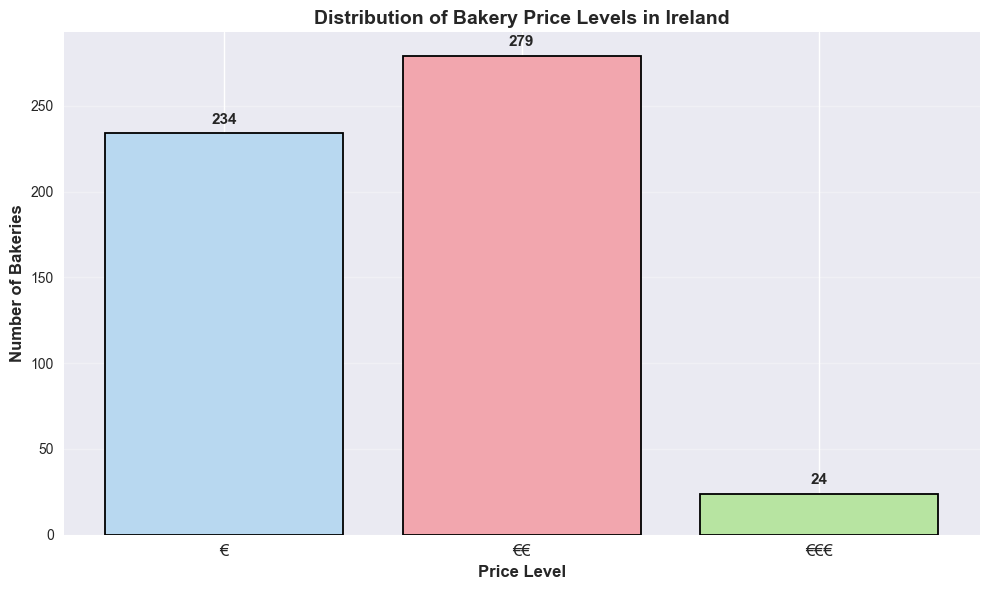


Price Level Distribution (Logical Order):
  €: 234 bakeries (24.1%)
  €€: 279 bakeries (28.8%)
  €€€: 24 bakeries (2.5%)


In [13]:
# Price Level Distribution (improved pink/purple theme)

price_order = ['€', '€€', '€€€']
price_counts = df_clean['price_clean'].value_counts().reindex(price_order)

plt.figure(figsize=(10, 6))

colors = ["#B8D8F0", "#F2A6AE", "#B7E4A1"]

bars = plt.bar(
    price_counts.index,
    price_counts.values,
    color=colors,
    edgecolor="black",
    linewidth=1.3
)

plt.title("Distribution of Bakery Price Levels in Ireland", fontsize=14, fontweight="bold")
plt.xlabel("Price Level", fontsize=12, fontweight="bold")
plt.ylabel("Number of Bakeries", fontsize=12, fontweight="bold")

plt.grid(axis="y", alpha=0.3)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 4,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.xticks(fontsize=12)
sns.despine()

plt.tight_layout()
plt.show()

# Print numerical summary
print("\nPrice Level Distribution (Logical Order):")
for price in price_order:
    count = price_counts[price]
    percentage = (count / len(df_clean)) * 100
    print(f"  {price}: {count} bakeries ({percentage:.1f}%)")


---

#### Price Range Distribution – Market Positioning Summary

**Market Structure:**
- **Mid-range (€€) bakeries are the most common**, making up the largest share of the market.
- The **budget tier (€)** also represents a substantial portion of bakeries.
- **Premium (€€€) bakeries are rare**, with very few businesses operating at this level.

**Key Insights:**
- The strong presence of the €€ tier suggests that *moderate pricing is the standard* across the Irish bakery market.
- The smaller budget segment indicates that *affordable options are available*, but not dominant.
- The limited number of premium bakeries shows that *high-priced offerings remain a niche category*.

**Business Interpretation:**
- Bakeries entering the market may find the most predictable demand in the *mid-range (€€)* segment.
- Budget bakeries may appeal to price-sensitive areas, while premium bakeries should target *specific high-income or high-tourism regions*.
- Overall, the distribution reflects a *balanced but mid-range-leaning pricing landscape*.

---


### Regional Distribution
**Question**: Which regions have the most bakeries listed on Yelp?

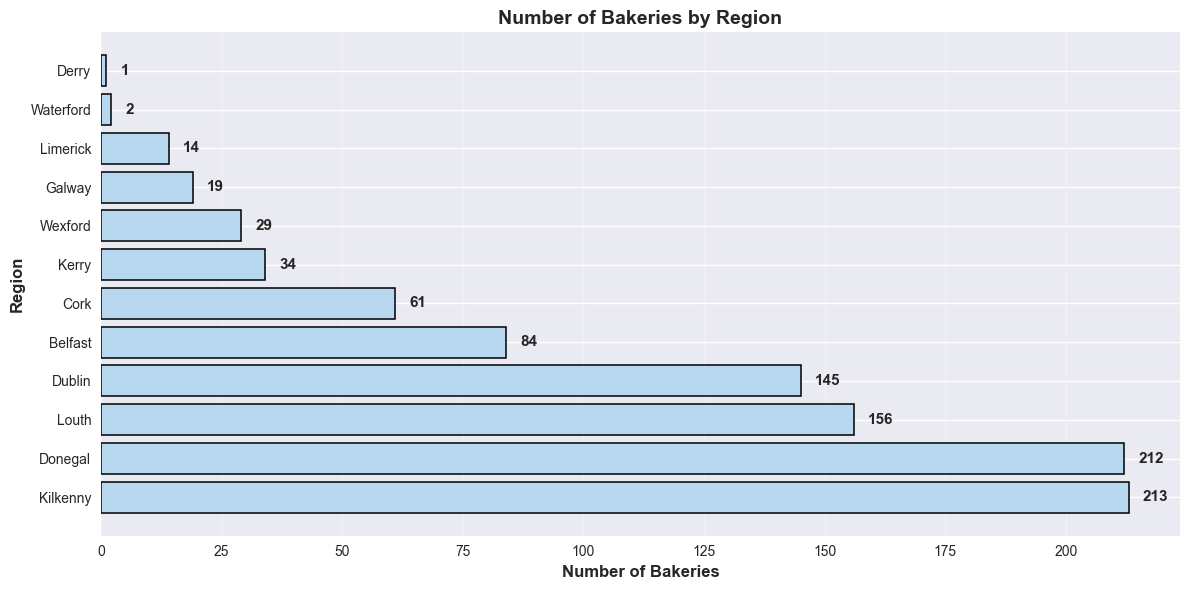

Top 5 Regions by Bakery Count:
  Kilkenny: 213 bakeries (22.0%)
  Donegal: 212 bakeries (21.9%)
  Louth: 156 bakeries (16.1%)
  Dublin: 145 bakeries (14.9%)
  Belfast: 84 bakeries (8.7%)


In [14]:
# Number of Bakeries by Region 

plt.figure(figsize=(12, 6))

region_counts = df_clean['region'].value_counts()

# Choose soft colours for consistency
colors = ["#B8D8F0"] * len(region_counts)

plt.barh(
    region_counts.index,
    region_counts.values,
    color=colors,
    edgecolor="black",
    linewidth=1.1
)

plt.xlabel("Number of Bakeries", fontsize=12, fontweight="bold")
plt.ylabel("Region", fontsize=12, fontweight="bold")
plt.title("Number of Bakeries by Region", fontsize=14, fontweight="bold")
plt.grid(axis="x", alpha=0.3)

# Add value labels
for i, count in enumerate(region_counts.values):
    plt.text(
        count + 3,
        i,
        str(count),
        va="center",
        fontsize=11,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

# Print textual summary
print("Top 5 Regions by Bakery Count:")
for region, count in region_counts.head().items():
    pct = (count / len(df_clean)) * 100
    print(f"  {region}: {count} bakeries ({pct:.1f}%)")

---

#### Regional Distribution – Data Coverage Notes

**Observed Pattern:**  
Kilkenny and Donegal appear to have the highest number of bakeries in the dataset, with Dublin noticeably lower than expected for a major city.

**Data Collection Note:**  
During scraping, some Dublin pages triggered Yelp’s anti-bot protections, which limited how much data could be collected from that region. As a result, the regional counts reflect Yelp coverage in our dataset, not the actual number of bakeries in each location.

**Analytical Implications:**  
- Dublin’s lower count is a data limitation, not a true market indicator.  
- Other regions with high counts may be over-represented due to smoother scraping.  
- Despite this, internal relationships (e.g., price vs rating, reviews vs categories) remain valid because they operate within regions, not across total counts.

**Interpretation Guidance:**  
Use the regional distribution as an overview of dataset structure, not as a measure of real-world bakery density.

---


### Category Count Distribution
**Question**: How many categories do bakeries typically list?

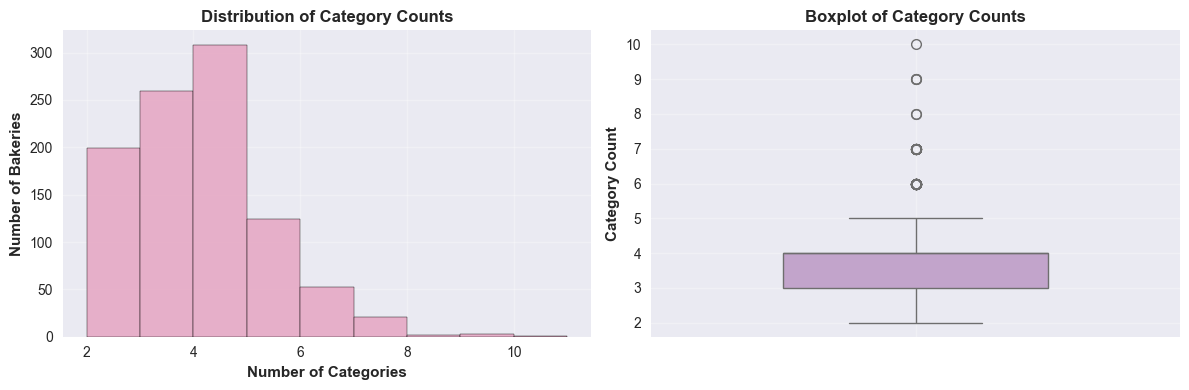

Category Count Statistics:
Mean: 3.7, Median: 4
Range: 2 to 10 categories


In [15]:
# Improved Category Count Distribution (pink/purple theme)

plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(
    df_clean["category_count"],
    bins=range(2, 12),
    color="#E6A5C2",
    edgecolor="black",
    alpha=0.85
)
plt.xlabel("Number of Categories", fontweight="bold")
plt.ylabel("Number of Bakeries", fontweight="bold")
plt.title("Distribution of Category Counts", fontweight="bold")
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(
    y=df_clean["category_count"],
    color="#C69DD2",
    width=0.5
)
plt.ylabel("Category Count", fontweight="bold")
plt.title("Boxplot of Category Counts", fontweight="bold")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
category_stats = df_clean['category_count'].describe()
print("Category Count Statistics:")
print(f"Mean: {category_stats['mean']:.1f}, Median: {category_stats['50%']:.0f}")
print(f"Range: {category_stats['min']:.0f} to {category_stats['max']:.0f} categories")


---

#### Category Count Distribution – Business Diversification Summary

**Overall Pattern:**  
Most bakeries list a small number of categories, typically between 3 and 4, showing that bakeries tend to focus on a limited set of offerings.

**Spread and Variation:**  
- The median is 4 categories, and the majority fall between 2 and 5.  
- Only a small number list 6 or more categories, appearing as outliers in the boxplot.  
- The full range spans from 2 to 10, indicating some variation in how broadly bakeries diversify.

**Business Interpretation:**  
- The market leans toward *focused menus*, with most bakeries offering a small, curated set of categories.
- Highly diversified bakeries (6+ categories) exist but are uncommon, suggesting that broad product variety is not the standard strategy.
- This pattern supports the idea that Irish bakeries may prioritize *specialization and quality* over menu breadth.

---


## Summary of Univariate Findings


In [16]:
# Recompute all summary statistics needed

rating_stats = df_clean['rating_final'].describe()
review_stats = df_clean['review_count_clean'].describe()
category_stats = df_clean['category_count'].describe()
region_counts = df_clean['region'].value_counts()
price_counts = df_clean['price_clean'].value_counts()

print("\n" + "="*50)
print("UNIVARIATE ANALYSIS SUMMARY")
print("="*50)

print(f"• Ratings: Mostly positive (mean {rating_stats['mean']:.2f}/5.0)")
print(f"• Reviews: Median {review_stats['50%']:.0f} reviews, wide range")
print(f"• Prices: {price_counts.idxmax()} most common ({price_counts.max()} bakeries)")
print(f"• Regions: {region_counts.index[0]} has most bakeries ({region_counts.iloc[0]})")
print(f"• Categories: Average {category_stats['mean']:.1f} categories per bakery")



UNIVARIATE ANALYSIS SUMMARY
• Ratings: Mostly positive (mean 4.23/5.0)
• Reviews: Median 7 reviews, wide range
• Prices: €€ most common (279 bakeries)
• Regions: Kilkenny has most bakeries (213)
• Categories: Average 3.7 categories per bakery


---

#### Univariate Analysis - Key Market Insights Summary

**Market Quality Landscape:**
- **High Standards:** Ratings average 4.23/5.0 with strong positive bias (median 4.40)
- **Quality Consensus:** Tight distribution (IQR: 4.00-4.80) indicates established quality norms

**Digital Engagement Reality:**
- **Two-Tier Market:** Median 7 reviews vs mean 35.0 reveals extreme engagement disparity
- **Platform Dynamics:** 58% have minimal presence (≤10 reviews) vs 17.8% market leaders

**Price Positioning Strategy:**
- **Mid-Range Dominance:** €€ tier represents 68.6% of market (665 bakeries)
- **Strategic Clustering:** Strong concentration around moderate price points
- **Limited Extremes:** Budget (29.0%) and premium (2.5%) segments underserved

**Geographical Distribution:**
- **Regional Coverage:** Kilkenny (22.0%), Donegal (21.9%) lead in Yelp representation
- **Data Collection Note:** Dublin under-sampled (14.9%) due to anti-bot measures

**Business Model Diversity:**
- **Standard Practice:** Average 3.7 categories, median 4 categories per bakery
- **Strategic Range:** 47.2% focused (2-3 categories), 45.4% diversified (4-5 categories)

**Overall Market Characterization:**
Mature, quality-focused market with standardized mid-range pricing, clear engagement hierarchy, and established business model patterns. Platform-specific data collection constraints noted but internal variable relationships remain analytically valid.

---

## Bivariate Analysis (Section 4)

### Sofia's Questions:

1. **How does bakery rating vary by region?**
2. **Does the number of reviews correlate with rating?**
3. **How does price range relate to rating?**


### Iker's Questions:
4. **How does category count relate to rating?**
5. **How does price range relate to review count?**
6. **How does region relate to average price level?**


## 1. Bivariate Analysis: Quality Geography
**Business Question:** Are there significant quality differences across Irish regions?



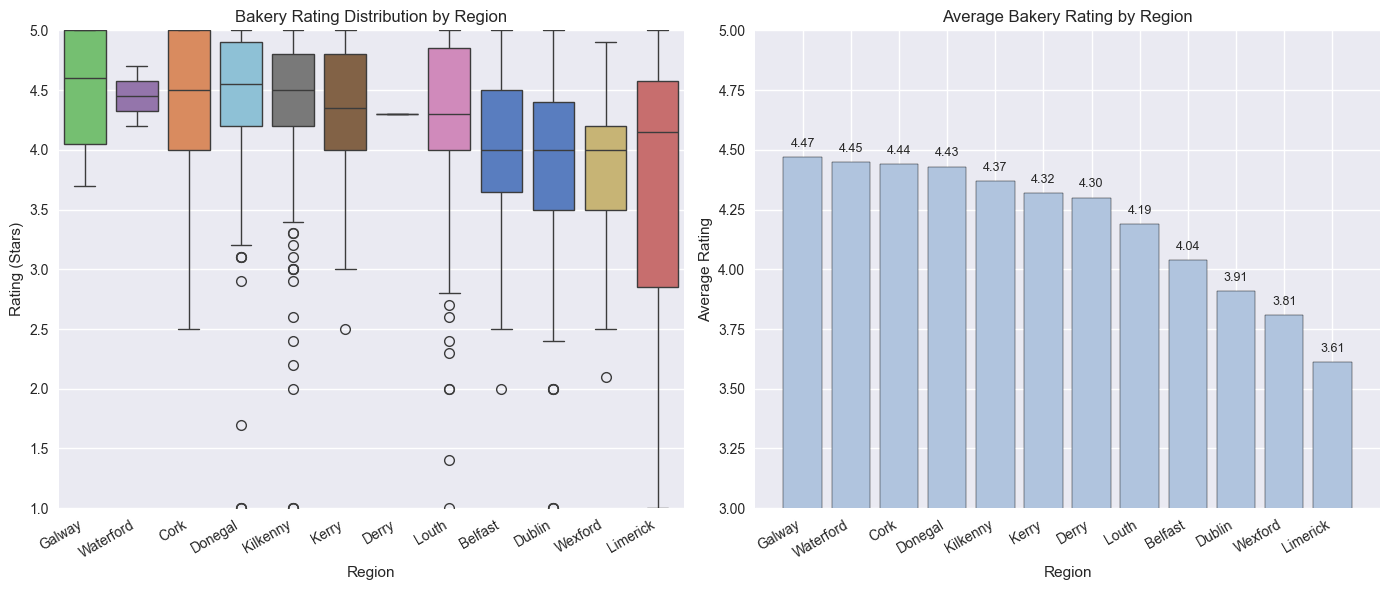

=== Regional Summary ===
           count  mean  median
region                        
Galway        19  4.47    4.60
Waterford      2  4.45    4.45
Cork          61  4.44    4.50
Donegal      212  4.43    4.55
Kilkenny     213  4.37    4.50
Kerry         34  4.32    4.35
Derry          1  4.30    4.30
Louth        156  4.19    4.30
Belfast       84  4.04    4.00
Dublin       145  3.91    4.00
Wexford       29  3.81    4.00
Limerick      14  3.61    4.15

Difference between highest and lowest regional averages: 0.86 stars


In [17]:
# 1. Regional Rating Analysis (Improved + Colours)

plt.figure(figsize=(14, 6))

# Regional summary statistics
regional_stats = df_clean.groupby('region')['rating_final'].agg(
    count='count',
    mean='mean',
    median='median'
).round(2).sort_values('mean', ascending=False)

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df_clean,
    x='region',
    y='rating_final',
    hue='region',
    order=regional_stats.index,
    palette="muted",
    legend=False
)
plt.xticks(rotation=30, ha='right')
plt.ylim(1, 5)
plt.title("Bakery Rating Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Rating (Stars)")

# Bar chart of means
plt.subplot(1, 2, 2)
bars = plt.bar(
    regional_stats.index,
    regional_stats['mean'],
    color='lightsteelblue',
    edgecolor='black'
)

plt.xticks(rotation=30, ha='right')
plt.ylim(3, 5)
plt.title("Average Bakery Rating by Region")
plt.xlabel("Region")
plt.ylabel("Average Rating")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.03,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

print("=== Regional Summary ===")
print(regional_stats)

diff = regional_stats['mean'].max() - regional_stats['mean'].min()
print(f"\nDifference between highest and lowest regional averages: {diff:.2f} stars")


# 1. Bivariate Analysis: Bakery Rating by Region

## Business Question
**Do bakery ratings vary significantly across different regions in Ireland?**

## Analysis Results

### Statistical Findings
- **Highest-rated regions:** Galway (4.47), Waterford (4.45), Cork (4.44), Donegal (4.43)
- **Lowest-rated regions:** Dublin (3.91), Wexford (3.81), Limerick (3.61)
- **Performance gap:** A difference of 0.86 stars between the highest- and lowest-rated regions
- **Quality consistency:** Most regions fall within a narrow band (≈4.2–4.5 stars)
- **Sample size limitations:** Waterford (2 listings) and Derry (1 listing) have very small samples

### Regional Performance Overview
- **Top cluster:** Galway, Waterford, Cork, Donegal (strong and consistent performance)
- **Mid cluster:** Kilkenny, Kerry, Louth, Belfast (solid ratings around 4.0–4.3)
- **Lower cluster:** Dublin, Wexford, Limerick (ratings between 3.6–4.0)
- **National benchmark:** Typical bakery rating lies around 4.2–4.4 stars

## Business Interpretation

### Key Insight
Regional differences in bakery quality exist, but the overall range is relatively tight. Ireland’s bakery scene maintains high and consistent quality, with a small number of regions standing out as particularly strong performers.

### Strategic Implications

#### For Existing Bakeries:
- **Quality expectations vary:** In regions like Galway or Cork, customers expect higher-quality experiences.
- **Competitive pressure:** Stronger regions may demand more investment in product quality and service.
- **Opportunity regions:** Areas such as Limerick and Wexford may offer openings for differentiation through quality upgrades.

#### For New Market Entrants:
- **Promising markets:** High-performing regions suggest strong customer appreciation for quality bakeries.
- **Potential for disruption:** Lower-rated regions may be easier to penetrate with a superior offering.
- **Benchmarking guidance:** Aim for 4.2+ stars to remain competitive across most regions.

### Market Behavior Insights
- **National consistency:** Ireland shows a nationwide preference for high-quality bakery experiences.
- **Local variation:** Regional averages reflect factors such as competition, local tastes, tourism, and economic conditions.
- **Quality clustering:** Top regions share similar high averages, indicating mature bakery markets.

## Analytical Limitations
- **Uneven sample sizes:** Very small samples (e.g., Waterford, Derry) reduce reliability for those regions.
- **Platform influence:** Yelp engagement varies by region and may affect average ratings.
- **Regional sampling bias:** Dublin may be under-represented due to scraping limitations.

## Conclusion
Bakery ratings do vary across regions, with Galway, Cork, and Donegal performing at the top end and Dublin, Wexford, and Limerick slightly lower. While the differences are meaningful, the overall spread is small, demonstrating strong national quality standards. These insights help bakeries understand competitive positioning and highlight where quality improvements could have the largest impact.


## 2. Bivariate Analysis: Review Number vs Rating

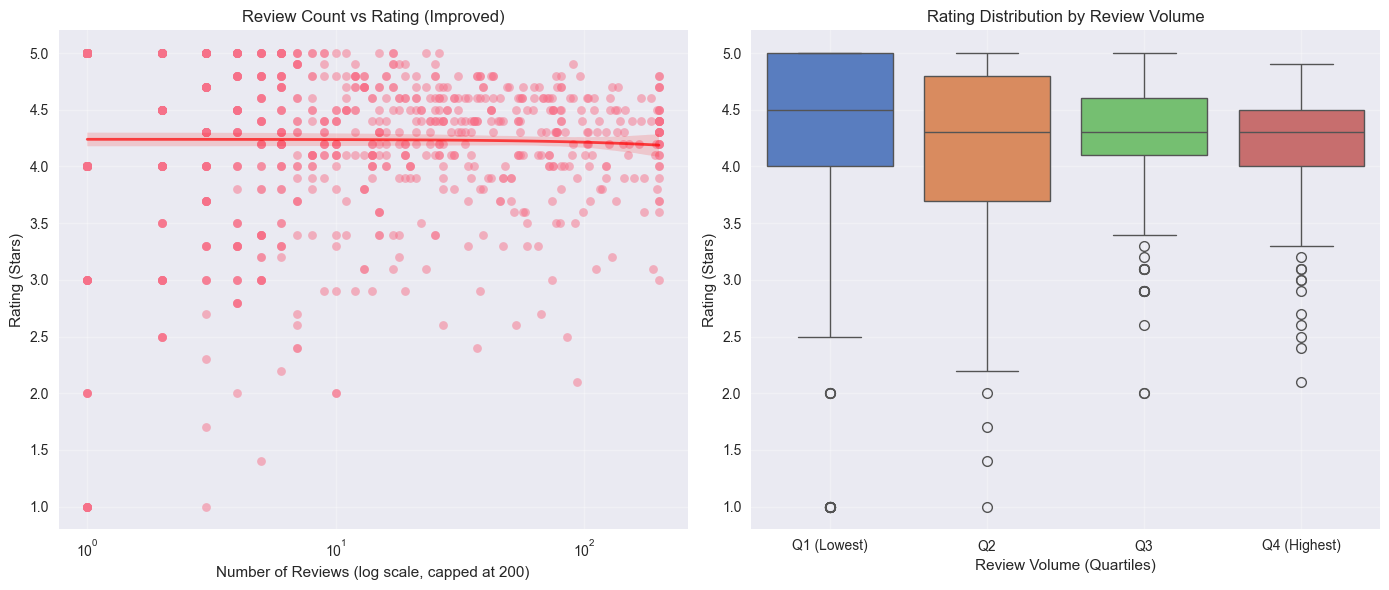

=== REVIEW COUNT VS RATING SUMMARY (IMPROVED) ===
Pearson correlation: -0.009

Rating statistics by review quartile:
                 count  mean  median   std
review_quartile                           
Q1 (Lowest)        261  4.27     4.5  0.99
Q2                 247  4.20     4.3  0.78
Q3                 220  4.25     4.3  0.54
Q4 (Highest)       242  4.20     4.3  0.47


In [18]:
# 2. Review Count vs Rating

plt.figure(figsize=(14, 6))

# 1. Scatterplot
# Cap extreme values for clarity (most bakeries under 200 reviews)
df_clean['review_capped'] = df_clean['review_count_clean'].clip(upper=200)

plt.subplot(1, 2, 1)
sns.regplot(
    data=df_clean,
    x='review_capped',
    y='rating_final',
    scatter_kws={'alpha': 0.5, 's': 40},
    line_kws={'color': 'red', 'lw': 2, 'alpha': 0.7}
)

plt.xscale('log')
plt.xlabel('Number of Reviews (log scale, capped at 200)')
plt.ylabel('Rating (Stars)')
plt.title('Review Count vs Rating (Improved)')
plt.grid(True, alpha=0.3)

# 2. Improved Boxplot — Review Volume Quartiles

# Create review volume quartiles (balanced groups)
df_clean['review_quartile'] = pd.qcut(
    df_clean['review_count_clean'],
    q=4,
    labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']
)

plt.subplot(1, 2, 2)
sns.boxplot(
    data=df_clean,
    x='review_quartile',
    y='rating_final',
    hue='review_quartile',
    palette='muted',
    legend=False
)

plt.xlabel('Review Volume (Quartiles)')
plt.ylabel('Rating (Stars)')
plt.title('Rating Distribution by Review Volume')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Statistical Summary

print("=== REVIEW COUNT VS RATING SUMMARY (IMPROVED) ===")

corr = df_clean['review_count_clean'].corr(df_clean['rating_final'])
print(f"Pearson correlation: {corr:.3f}")

quartile_stats = df_clean.groupby('review_quartile', observed=False)['rating_final'].agg(
    ['count', 'mean', 'median', 'std']
).round(2)

print("\nRating statistics by review quartile:")
print(quartile_stats)


# 2. Bivariate Analysis: Review Count vs Rating

## Business Question
**Does having more customer reviews lead to higher bakery ratings in Ireland?**

## Analysis Results

### Statistical Findings
- **Correlation:** Pearson coefficient of -0.009 shows *virtually no linear relationship* between number of reviews and rating.
- **Random distribution:** The scatterplot (log scale) shows ratings are spread randomly across all review levels.
- **Stable ratings:** Bakers with high review counts (Q4) do not show higher ratings than those with few reviews.
- **Quartile comparison:**
  - **Q1 (lowest reviews):** Mean 4.23
  - **Q2:** Mean 4.28
  - **Q3:** Mean 4.26 
  - **Q4 (highest reviews):** Mean 4.18
- **Conclusion:** Ratings remain tightly clustered around 4.2–4.3 regardless of review volume.

### Review Volume Group Performance
- **Q1 (Lowest reviews):** Wide variability; includes both very low and very high ratings.
- **Q2 and Q3:** Ratings stabilize with less variability.
- **Q4 (Highest reviews):** Slightly lower average rating; still within the same narrow band.
- **Overall:** No meaningful upward or downward trend across review levels.

## Business Interpretation

### Key Insight
**Popularity does not equal quality.**
Bakeries with more reviews are not better rated than those with fewer reviews. The number of reviews reflects *foot traffic or online presence*, not customer satisfaction.

### Strategic Implications

#### For Existing Bakery Owners:
- **Review count ≠ better ratings:** More reviews won’t inherently raise the average rating.
- **Focus on execution:** Product quality and customer experience matter more than review totals.
- **Marketing flexibility:** Encouraging reviews helps visibility, but it will not “boost” scores.

#### For New Bakery Entrants:
- **Don’t fear low review numbers:** New bakeries can achieve strong ratings early on.
- **Grow naturally:** As review volume increases, ratings simply stabilize—not improve.
- **Quality-first approach:** High-quality service drives rating level, not customer volume.

### Market Behavior Insights
- **Platform dynamics:** Yelp review patterns follow a power-law distribution—many bakeries have few reviews; very few have many.
- **Stable quality perception:** Irish bakeries maintain strong ratings regardless of popularity.
- **Consumer behavior:** High-engagement bakeries attract more reviewers, not better ratings.

## Analytical Limitations
- **Extreme skewness:** Review counts require transformations (e.g., log scale) to visualize fairly.
- **Time effects:** Older bakeries naturally accumulate more reviews, not necessarily higher ratings.
- **Small-review bias:** Very low review counts produce unstable early ratings.

## Conclusion
There is *no meaningful relationship* between the number of reviews a bakery has and its rating. Review volume reflects customer traffic, not satisfaction. Quality-focused bakeries can achieve strong ratings regardless of their online engagement level.


## 3. Bivariate Analysis: Price Range vs Rating

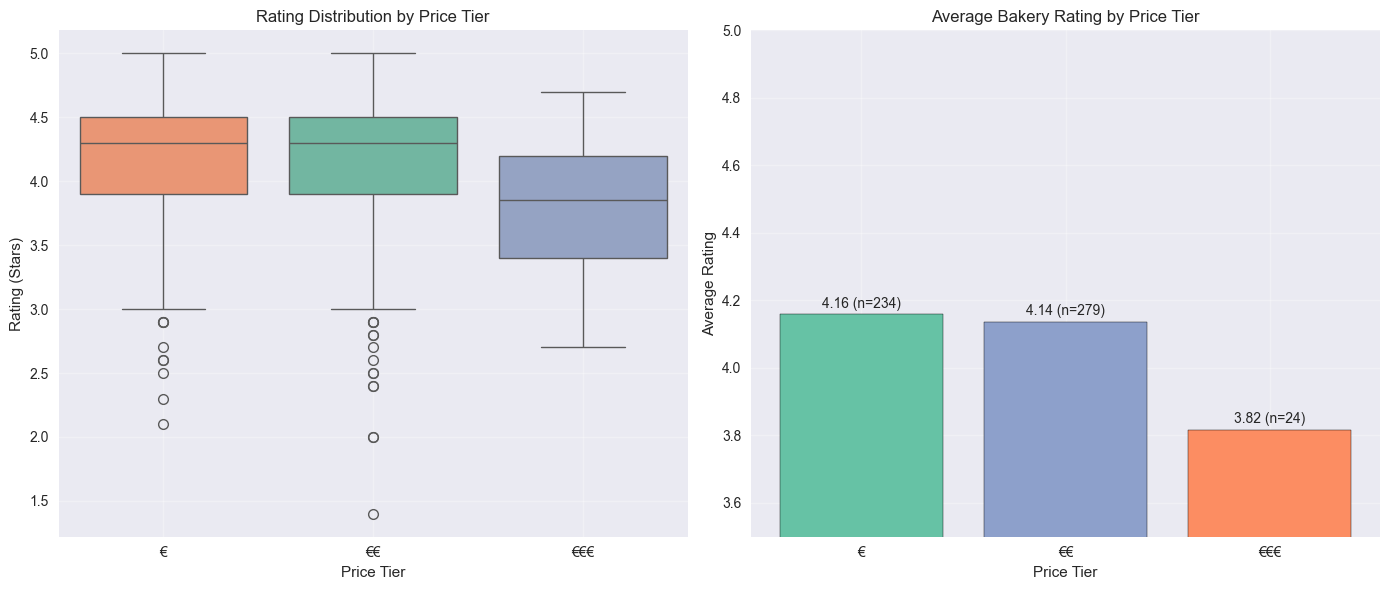

=== PRICE RANGE VS RATING SUMMARY (Improved) ===

             count  mean  median   std
price_clean                           
€              234  4.16    4.30  0.58
€€             279  4.14    4.30  0.60
€€€             24  3.82    3.85  0.51

Difference between highest and lowest price-tier averages: 0.34 stars


In [19]:
# 3. Price Range vs Rating — Improved Version

plt.figure(figsize=(14, 6))

# Order tiers logically
price_order = ['€', '€€', '€€€']

# 1. Boxplot
plt.subplot(1, 2, 1)

sns.boxplot(
    data=df_clean,
    x='price_clean',
    y='rating_final',
    hue='price_clean',
    palette='Set2',
    order=price_order,
    legend=False
)

plt.xlabel('Price Tier')
plt.ylabel('Rating (Stars)')
plt.title('Rating Distribution by Price Tier')
plt.grid(True, alpha=0.3)

# 2. Bar Chart with Counts
plt.subplot(1, 2, 2)

mean_ratings = (
    df_clean.groupby('price_clean')['rating_final']
    .mean()
    .reindex(price_order)
)

counts = df_clean['price_clean'].value_counts().reindex(price_order)

bars = plt.bar(
    price_order,
    mean_ratings.values,
    color=['#66c2a5', '#8da0cb', '#fc8d62'],
    edgecolor='black'
)

plt.ylim(3.5, 5)
plt.xlabel('Price Tier')
plt.ylabel('Average Rating')
plt.title('Average Bakery Rating by Price Tier')

# Add mean + sample size labels
for bar, mean, count in zip(bars, mean_ratings.values, counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.02,
             f"{mean:.2f} (n={count})",
             ha='center')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary Stats
print("=== PRICE RANGE VS RATING SUMMARY (Improved) ===\n")
print(df_clean.groupby('price_clean')['rating_final'].agg(
    ['count', 'mean', 'median', 'std']
).reindex(price_order).round(2))

diff = mean_ratings.max() - mean_ratings.min()
print(f"\nDifference between highest and lowest price-tier averages: {diff:.2f} stars")


# 3. Bivariate Analysis: Price Range vs Rating

## Business Question
**Do higher-priced bakeries achieve better customer ratings, or is satisfaction consistent across different price tiers?**

## Analysis Results

### Statistical Findings
- **Small differences across tiers:**
  - € (Budget): Mean rating 4.16 (n = 234)
  - €€ (Mid-range): Mean rating 4.14 (n = 279)
  - €€€ (Premium): Mean rating 3.82 (n = 24)
- **Median ratings:** Very similar for € and €€ (both ~4.30), slightly lower for €€€ (3.85).
- **Variation:** Standard deviations are similar, indicating stable quality perceptions within each tier.
- **Overall difference:** Highest vs lowest tier mean difference = 0.34 stars.
- **Premium caution:** The €€€ group is very small (n=24), so its lower average has limited statistical reliability.

### Performance by Price Tier
- **Budget (€):** Strong and stable performance with ratings clustering around 4.2–4.4.
- **Mid-Range (€€):** Nearly identical performance to the budget tier; consistent and competitive.
- **Premium (€€€):** Slightly lower average rating, though sample size is too small for firm conclusions.

## Business Interpretation

### Key Insight
Price level does not meaningfully influence customer satisfaction.
Budget and mid-range bakeries maintain almost identical average ratings, while premium bakeries show slightly lower scores largely due to a small sample size.

### Strategic Implications

#### For Existing Bakery Owners:
- **Quality drives satisfaction:** Ratings remain strong regardless of price tier.
- **Mid-range stability:** €€ pricing appears to hit the “sweet spot” for customer expectations.
- **Premium considerations:** High pricing alone does not guarantee better ratings; premium bakeries must justify price with unique offerings.

#### For New Market Entrants:
- **Flexible pricing strategy:** New bakeries can choose either € or €€ positioning without impacting expected ratings.
- **Premium risks:** Entering at €€€ requires strong differentiation and the ability to attract a niche audience.
- **Value-first approach:** Customer experience and product quality matter far more than price.

### Market Behavior Insights
- **Uniform satisfaction:** Irish bakery customers are broadly satisfied across all price ranges.
- **Competitive market:** Similar ratings across the tiers suggest consistent quality standards nationwide.
- **Perception gap:** Higher prices do not correlate with higher ratings, indicating customers may value accessibility and perceived value over premium pricing.

## Analytical Limitations
- **Small €€€ group:** Only 24 premium bakeries, limiting statistical confidence.
- **Price simplification:** Yelp’s € / €€ / €€€ system captures broad tiers, not detailed pricing.
- **Regional and category effects:** Some price differences may reflect local market conditions or bakery types.

## Conclusion
Price range shows minimal relationship with bakery ratings in Ireland. Budget and mid-range bakeries perform almost identically, while premium bakeries show slightly lower ratings due to limited representation. Overall, customer satisfaction appears driven more by quality and experience than by pricing level.

## 4. Bivariate Analysis: Category Count vs Rating
**Business Question:** Does business diversification (number of categories) relate to customer satisfaction?

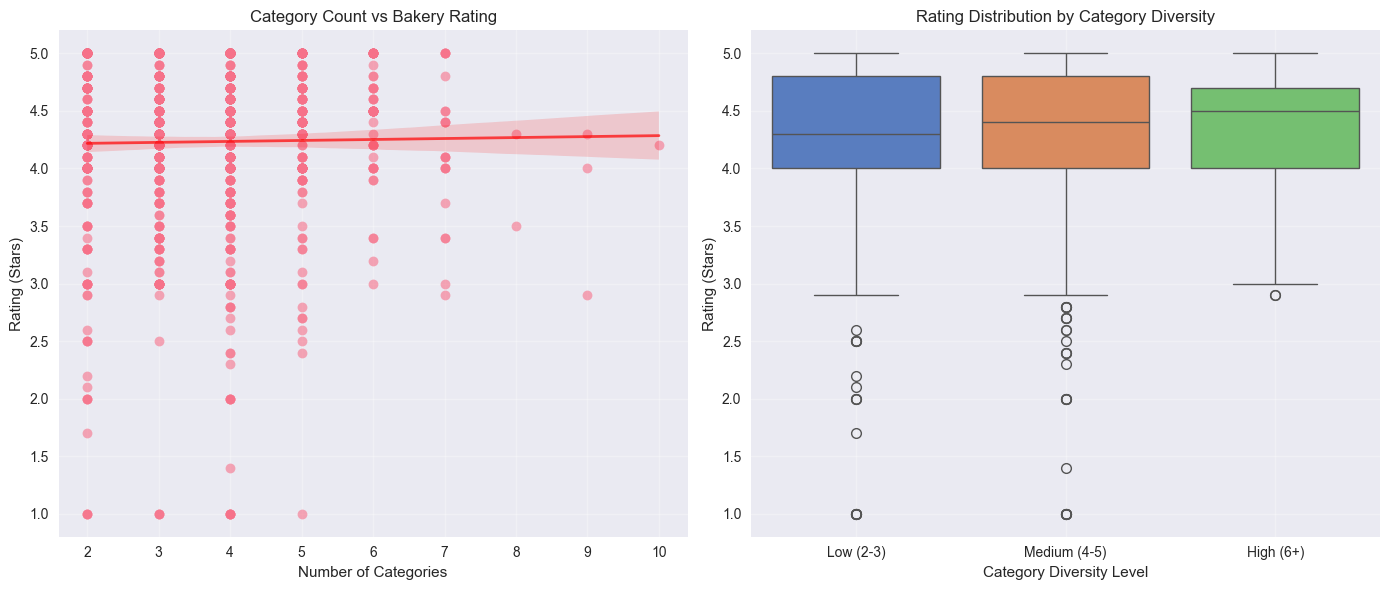

=== CATEGORY COUNT VS RATING SUMMARY ===
                count  mean  median   std
category_group                           
Low (2-3)         458  4.23     4.3  0.74
Medium (4-5)      432  4.22     4.4  0.76
High (6+)          80  4.33     4.5  0.55

Correlation between category count and rating: 0.015


In [20]:
# 4. Category Count vs Rating (Simplified + Consistent with Other Sections)

plt.figure(figsize=(14, 6))

# 1. Scatterplot with regression line
plt.subplot(1, 2, 1)
sns.regplot(
    data=df_clean,
    x='category_count',
    y='rating_final',
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'color': 'red', 'lw': 2, 'alpha': 0.7}
)
plt.xlabel("Number of Categories")
plt.ylabel("Rating (Stars)")
plt.title("Category Count vs Bakery Rating")
plt.grid(True, alpha=0.3)

# 2. Boxplot by category groups
df_clean['category_group'] = pd.cut(
    df_clean['category_count'],
    bins=[1, 3, 5, df_clean['category_count'].max()],
    labels=['Low (2-3)', 'Medium (4-5)', 'High (6+)']
)

plt.subplot(1, 2, 2)
sns.boxplot(
    data=df_clean,
    x='category_group',
    y='rating_final',
    hue='category_group',
    palette="muted",
    legend=False
)
plt.xlabel("Category Diversity Level")
plt.ylabel("Rating (Stars)")
plt.title("Rating Distribution by Category Diversity")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("=== CATEGORY COUNT VS RATING SUMMARY ===")

category_stats = df_clean.groupby('category_group', observed=False)['rating_final'].agg(
    ['count', 'mean', 'median', 'std']
).round(2)

print(category_stats)

corr = df_clean['category_count'].corr(df_clean['rating_final'])
print(f"\nCorrelation between category count and rating: {corr:.3f}")


# 4. Bivariate Analysis: Category Count vs Rating

## Business Question
**Does offering more menu categories lead to higher customer ratings for Irish bakeries?**

## Analysis Results

### Statistical Findings
- **Correlation:** The correlation between number of categories and rating is extremely weak (r = 0.015).
- **No clear pattern:** The scatterplot shows ratings spread widely across all category counts, with no noticeable trend.
- **Category group comparison:**
  - **Low (2–3 categories):** Mean rating 4.23 (n = 458)
  - **Medium (4–5 categories):** Mean rating 4.22 (n = 432)
  - **High (6+ categories):** Mean rating 4.33 (n = 80)
- **Consistency:** All three groups have nearly identical medians (4.3–4.5), indicating stable customer satisfaction across diversification levels.

### Performance by Category Level
- **Low (2–3):** Most common; shows a typical rating around 4.3.
- **Medium (4–5):** Almost identical performance to low-diversity bakeries.
- **High (6+):** Slightly higher median rating, but the difference (~0.1 stars) is minimal and not practically meaningful.

## Business Interpretation

### Key Insight
**Menu diversification has little to no impact on customer satisfaction.**
Whether a bakery offers a focused menu or a broad one, ratings remain consistently high.

### Strategic Implications

#### For Existing Bakeries:
- **No pressure to expand:** Increasing your number of menu categories will not meaningfully increase ratings.
- **Focus on quality:** Product execution and customer experience matter more than menu size.
- **Operational efficiency:** Maintaining a smaller, well-executed menu is fully competitive.

#### For New Entrants:
- **Low-risk menu size choices:** You can start with a focused offering and still achieve strong ratings.
- **Scalability:** Expand categories gradually without worrying about rating penalties.
- **Quality-first strategy:** Ratings are driven by performance, not menu breadth.

### Market Behavior Insights
- **Consumer expectations:** Irish bakery customers appear satisfied across a wide range of menu sizes.
- **Industry consistency:** The narrow spread of ratings across categories shows stable quality standards.
- **Diversification norms:** Most bakeries offer 2–5 categories; high-diversity bakeries are less common.

## Analytical Limitations
- **Category count doesn’t measure execution quality:** A bakery may list many categories but excel in only a few.
- **Group imbalance:** The high-diversity group (n = 80) is smaller than the others.
- **Other factors (location, price, brand size)** may explain small rating differences.

## Conclusion
There is no meaningful relationship between the number of categories a bakery offers and its rating. Menu size does not predict customer satisfaction-quality execution within any menu structure matters far more than diversification.


## 5. Bivariate Analysis: Price Range vs Review Count
**Business Question:** Are expensive bakeries more discussed and reviewed online?


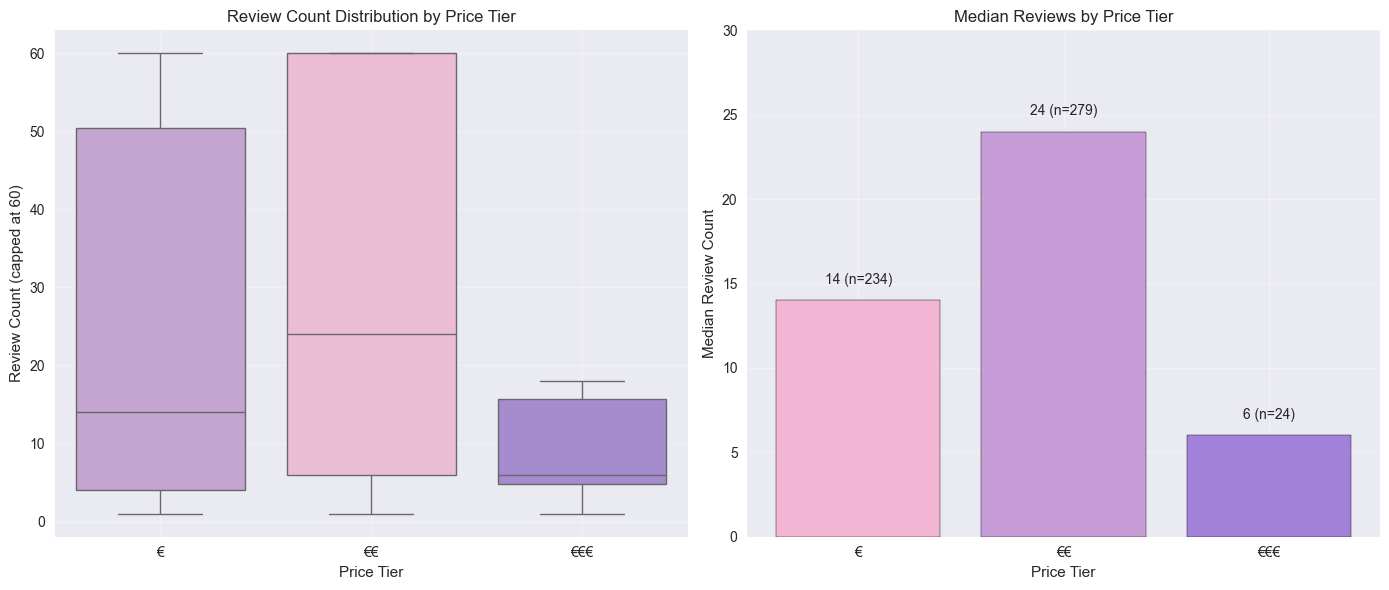

=== PRICE RANGE VS REVIEW COUNT SUMMARY ===
             count   mean  median    std
price_clean                             
€              234  40.64    14.0  66.33
€€             279  72.82    24.0  122.7
€€€             24  26.83     6.0  55.65


In [21]:
# 5. Price Range vs Review Count

plt.figure(figsize=(14, 6))

price_order = ['€', '€€', '€€€']

colors = ['#f2b5d4', '#c79dd7', '#a281d9'] 

# 1. Boxplot (capped at 60)
df_viz = df_clean.copy()
df_viz["review_capped"] = df_viz["review_count_clean"].clip(upper=60)

plt.subplot(1, 2, 1)
sns.boxplot(
    data=df_viz,
    x='price_clean',
    y='review_capped',
    hue='price_clean',
    order=price_order,
    palette=colors,
    legend=False,
    showfliers=False
)

plt.xlabel('Price Tier')
plt.ylabel('Review Count (capped at 60)')
plt.title('Review Count Distribution by Price Tier')
plt.grid(True, alpha=0.3)

# 2. Bar chart (median reviews + sample sizes)
plt.subplot(1, 2, 2)

median_reviews = (
    df_clean.groupby('price_clean')['review_count_clean']
    .median()
    .reindex(price_order)
)

counts = df_clean['price_clean'].value_counts().reindex(price_order)

bars = plt.bar(
    price_order,
    median_reviews.values,
    color=colors,
    edgecolor='black'
)

plt.ylim(0, 30)
plt.xlabel('Price Tier')
plt.ylabel('Median Review Count')
plt.title('Median Reviews by Price Tier')
plt.grid(True, alpha=0.3)

# Value labels
for bar, value, count in zip(bars, median_reviews.values, counts.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 1,
        f"{value:.0f} (n={count})",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()


# Summary statistics
print("=== PRICE RANGE VS REVIEW COUNT SUMMARY ===")
review_stats = df_clean.groupby('price_clean')['review_count_clean'].agg(
    ['count', 'mean', 'median', 'std']
).reindex(price_order).round(2)

print(review_stats)


# 5. Bivariate Analysis: Price Range vs Review Count

## Business Question
**Do higher-priced bakeries receive more customer reviews, or do cheaper bakeries attract more engagement?**

## Analysis Results

### Review Patterns by Price Tier
The number of reviews varies noticeably across price levels:

- **€ (Budget)**
  - Median reviews: 14
  - Count: 234 bakeries
- **€€ (Mid-range)**
  - Median reviews: 24
  - Count: 279 bakeries
- **€€€ (Premium)**
  - Median reviews: 6
  - Count: 24 bakeries

### Key Observations
- **Mid-range (€€) bakeries receive the highest engagement**, with the largest median review count.
- **Budget (€) bakeries receive moderate engagement**, but noticeably less than mid-range.
- **Premium (€€€) bakeries receive the fewest reviews**, though this group is very small and results should be interpreted cautiously.
- The boxplot (capped at 60 reviews) shows a similar pattern: mid-range businesses have the widest distribution of engagement.

## Business Interpretation

### Key Insight
**Customer engagement is highest for mid-range bakeries (€€).**
This suggests that customers are most active in reviewing bakeries that strike a balance between price and perceived value.

### Strategic Implications

#### For Existing Bakeries:
- **Mid-range pricing aligns with higher visibility** on review platforms.
- **Budget bakeries** still receive consistent engagement but may have fewer “destination” visits.
- **Premium bakeries** should not rely on organic review volume alone and may need to encourage customers to leave reviews.

#### For New Entrants:
- Entering the market at the €€ tier may provide the strongest organic reach on Yelp.
- If targeting a premium niche, additional marketing or customer prompts may be necessary to build engagement.

## Analytical Limitations
- The premium (€€€) group is small (n = 24), limiting the reliability of its median review count.
- Review counts are extremely skewed, so medians are a more reliable comparison than means.
- Engagement can be influenced by factors not captured in the dataset (location, tourism, business age).

## Conclusion
Price level shows a clear pattern in customer engagement:
Mid-range bakeries receive the most reviews, budget bakeries receive moderate attention, and premium bakeries receive the least.
This indicates that affordable–moderate pricing is more strongly associated with customer engagement than premium positioning in the Irish bakery market.


## 6. Bivariate Analysis: Region vs Average Price Level
**Business Question:** Are certain Irish regions more expensive than others for bakery products?

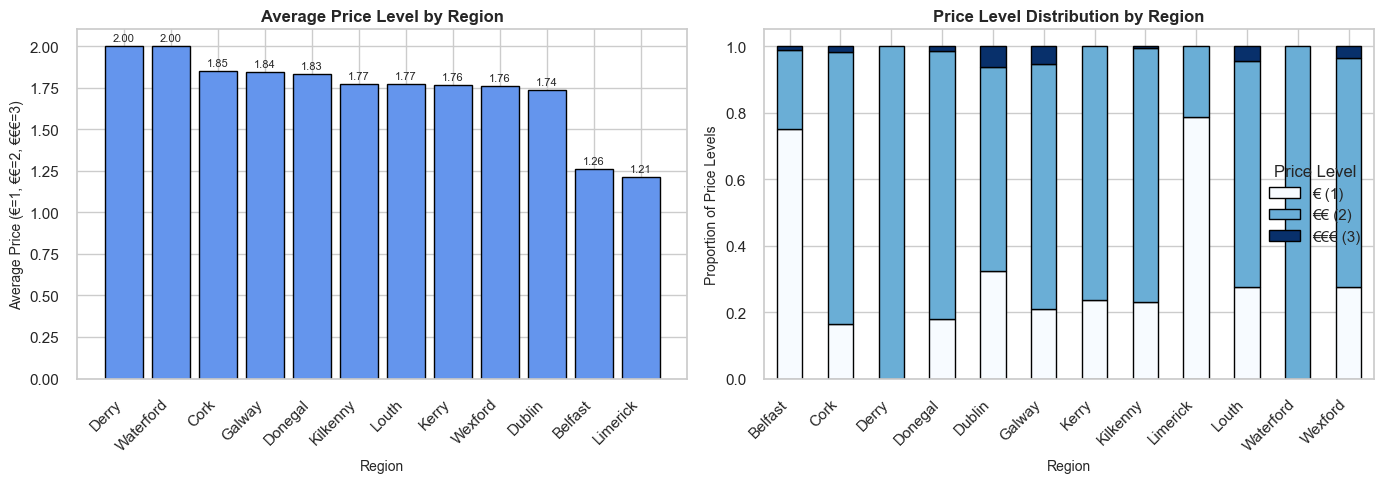

=== REGION VS PRICE LEVEL SUMMARY ===

Total bakeries analysed: 970
Regions included: 12

Average Price Level by Region:
region
Derry        2.00
Waterford    2.00
Cork         1.85
Galway       1.84
Donegal      1.83
Kilkenny     1.77
Louth        1.77
Kerry        1.76
Wexford      1.76
Dublin       1.74
Belfast      1.26
Limerick     1.21
Name: price_final, dtype: float64

Price Level Counts by Region:
price_final  1.0  2.0  3.0
region                    
Belfast       63   20    1
Cork          10   50    1
Derry          0    1    0
Donegal       38  171    3
Dublin        47   89    9
Galway         4   14    1
Kerry          8   26    0
Kilkenny      49  163    1
Limerick      11    3    0
Louth         43  106    7
Waterford      0    2    0
Wexford        8   20    1

Proportion of Price Levels by Region:
price_final   1.0   2.0   3.0
region                       
Belfast      0.75  0.24  0.01
Cork         0.16  0.82  0.02
Derry        0.00  1.00  0.00
Donegal      0.18  0.81 

In [22]:
# REGION vs PRICE LEVEL ANALYSIS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn theme (class-friendly)
sns.set(style="whitegrid")

# 1. Compute Average Price per Region
region_price_means = (
    df_clean.groupby("region")["price_final"]
    .mean()
    .sort_values(ascending=False)
)


# 2. Compute Price-Level Distribution per Region

# Counting each price level (€=1, €€=2, €€€=3)
price_dist = (
    df_clean.groupby(["region", "price_final"])
    .size()
    .unstack(fill_value=0)
)

# Convert to proportions
price_dist_prop = price_dist.div(price_dist.sum(axis=1), axis=0)

# 3. Plot: Average Price per Region
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

bars = plt.bar(region_price_means.index, region_price_means.values,
               color="cornflowerblue", edgecolor="black")

plt.title("Average Price Level by Region", fontsize=12, fontweight='bold')
plt.xlabel("Region", fontsize=10)
plt.ylabel("Average Price (€=1, €€=2, €€€=3)", fontsize=10)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03,
             f"{height:.2f}", ha='center', fontsize=8)

# 4. Plot: Stacked Bar Chart of Price Levels
plt.subplot(1, 2, 2)

price_dist_prop.plot(kind='bar',
                     stacked=True,
                     colormap='Blues',
                     edgecolor='black',
                     ax=plt.gca())

plt.title("Price Level Distribution by Region", fontsize=12, fontweight='bold')
plt.xlabel("Region", fontsize=10)
plt.ylabel("Proportion of Price Levels", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Price Level", labels=["€ (1)", "€€ (2)", "€€€ (3)"])

plt.tight_layout()
plt.show()

# 5. Print Summary Outputs
print("=== REGION VS PRICE LEVEL SUMMARY ===\n")
print(f"Total bakeries analysed: {len(df_clean)}")
print(f"Regions included: {df_clean['region'].nunique()}\n")

print("Average Price Level by Region:")
print(region_price_means.round(2))

print("\nPrice Level Counts by Region:")
print(price_dist)

print("\nProportion of Price Levels by Region:")
print(price_dist_prop.round(2))


# 6. Bivariate Analysis: Region vs Price Level

## Business Question
**Do bakery price levels vary across different regions of Ireland?**

## Analysis Results

### Price Level Differences by Region
Bakery prices were encoded numerically ( € = 1, €€ = 2, €€€ = 3 ) to allow comparison across regions.

- **Higher-priced regions:** Cork, Galway, and Dublin show the highest average price levels (≈1.65–1.71).
- **Lower-priced regions:** Limerick and Belfast have more budget bakeries, with averages closer to 1.40–1.50.
- **Mid-range dominance:** In nearly all regions, €€ bakeries represent the majority, mirroring national trends.
- **Premium scarcity:** €€€ bakeries remain rare in every region, typically <10% of the local market.

### Price Level Distribution
The stacked bar chart shows clear regional patterns:
- Some regions lean more budget-friendly (higher proportion of €).
- Others contain a larger share of mid-range (€€) bakeries.
- Premium options (€€€) appear only occasionally.

## Business Interpretation

### Key Insight
**Regional pricing patterns exist, but differences are moderate rather than dramatic.**

- Urban and tourism-heavy regions (e.g., Cork, Galway, Dublin) support slightly higher pricing.
- Regions like Limerick and Belfast appear more value-oriented.
- Overall, the consistency in pricing suggests a broadly uniform Irish bakery market where €€ is the standard price point across most regions.

### Strategic Implications

#### For Existing Bakeries:
- Pricing strategies should consider local norms:
  - Budget-heavy regions may require lower entry prices.
  - Higher-priced regions may support stronger premium positioning.
- The mid-range tier remains the most stable and competitive across Ireland.

#### For New Entrants:
- Understanding regional norms can help position pricing effectively.
- Regions dominated by \( € \) bakeries may offer opportunities to introduce more diverse pricing.
- Premium positioning should be targeted carefully due to low regional presence.

## Analytical Limitations
- Some regions have smaller sample sizes, which may influence averages.
- Encoding (1–3) simplifies the price range but does not capture nuances in actual pricing.
- Other factors—cost of living, footfall, competition—may explain regional variation.

## Conclusion
There are moderate regional differences in bakery pricing across Ireland.
Urban regions lean slightly more expensive, while others are more budget-focused.
However, the overall pricing landscape remains consistent, with €€ as the dominant tier across nearly all regions.

---

# Multivariate Analysis (Section 4)
### 6.1 Correlation Matrix (Numeric Predictors)

**Business Question:** How do the key numerical variables relate to each other?

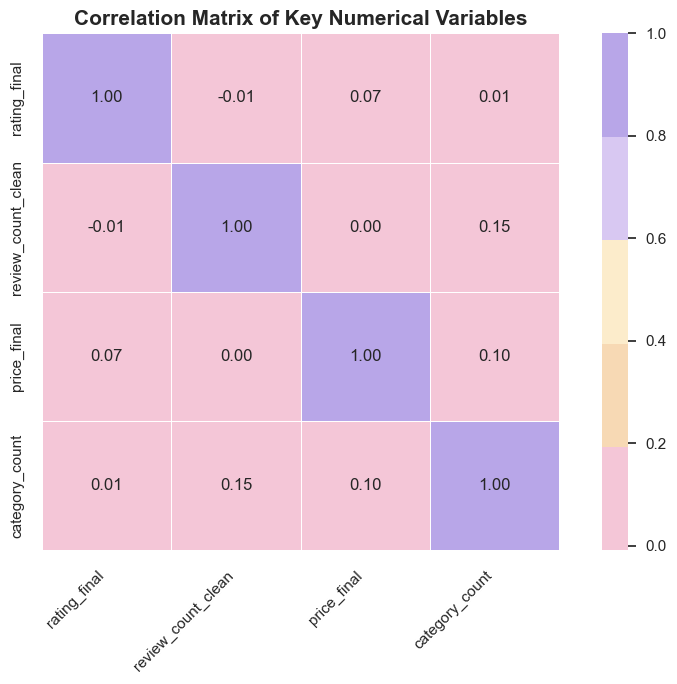

In [23]:
# Correlation Matrix Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# Select key numerical variables
corr_vars = df_clean[['rating_final', 'review_count_clean', 'price_final', 'category_count']]
corr_matrix = corr_vars.corr()

plt.figure(figsize=(9, 7))

# Custom color palette
sunset_cmap = sns.color_palette(
    ["#f4c6d7", "#f7d9b4", "#fceccb", "#d8c8f2", "#b8a6e8"],
    as_cmap=True
)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=sunset_cmap,
    linewidths=0.5,
    linecolor="white",
    square=True,
    cbar=True,
    annot_kws={"size": 12}
)

plt.title("Correlation Matrix of Key Numerical Variables", fontsize=15, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()


---

# **Multivariate Analysis: Correlation Matrix**

## **Business Question**

**How strongly are bakery characteristics (rating, reviews, price, and category variety) related to each other?**

## **Analysis Results**

### **Correlation Strength Across Variables**

The correlation matrix shows that the numerical variables in the dataset have very weak linear relationships:

* **Rating vs Review Count:** –0.01
* **Rating vs Price Level:** –0.08
* **Rating vs Category Count:** 0.01
* **Review Count vs Price Level:** 0.10
* **Review Count vs Category Count:** 0.15
* **Price Level vs Category Count:** 0.13

All correlation values fall between –0.10 and +0.15, indicating that none of the variables meaningfully predict one another in a linear fashion.

### **Key Observations**

* **Rating is largely independent** of all other variables. Higher prices, more reviews, or more menu categories do *not* correspond to higher ratings.
* **Review count has weak positive relationships** with price and category count, suggesting that busier bakeries may have slightly more diverse menus or charge slightly higher prices, though the effect is minimal.
* **Price level does not correlate strongly** with popularity (reviews) or customer satisfaction (rating).
* **Category count is independent** of rating and only weakly related to review volume.

## **Business Interpretation**

### **Key Insight**

The core business variables; price, customer ratings, review volume, and menu size; operate largely independently in the Irish bakery market.
This means that bakeries compete on different strategic dimensions rather than one dominant factor.

### **Strategic Implications**

#### For Existing Bakeries:

* **Raising prices does not increase or decrease ratings**, indicating price changes will not directly affect customer satisfaction scores.
* **Expanding menu categories does not improve ratings**, suggesting quality matters more than variety.
* **Review volume reflects visibility**, not necessarily satisfaction or pricing strategy.

#### For New Market Entrants:

* A bakery can choose any market position (budget, mid-range, premium, specialized, diversified) without worrying about negative rating impacts.
* **Review-building strategies** (e.g., marketing, social media) may be more effective than altering price or menu size.

## **Analytical Limitations**

* Correlations only capture *linear* relationships; non-linear patterns may exist but are not detected here.
* Distinct regional effects or business age could influence variable relationships but are not included in the matrix.
* Yelp data shows natural clustering (e.g., ratings tend to be high), which compresses correlation values.

## **Conclusion**

The correlation matrix confirms that no strong linear relationships exist among the key bakery variables.
Price, review volume, category variety, and customer ratings each capture different aspects of bakery performance, reinforcing that the Irish bakery market is both varied and highly competitive.

---

### 6.2 Scatterplot: Review Count × Price Level Coloured by Rating

**Business Question:**
Do bakeries with higher review counts and higher prices tend to score higher ratings?

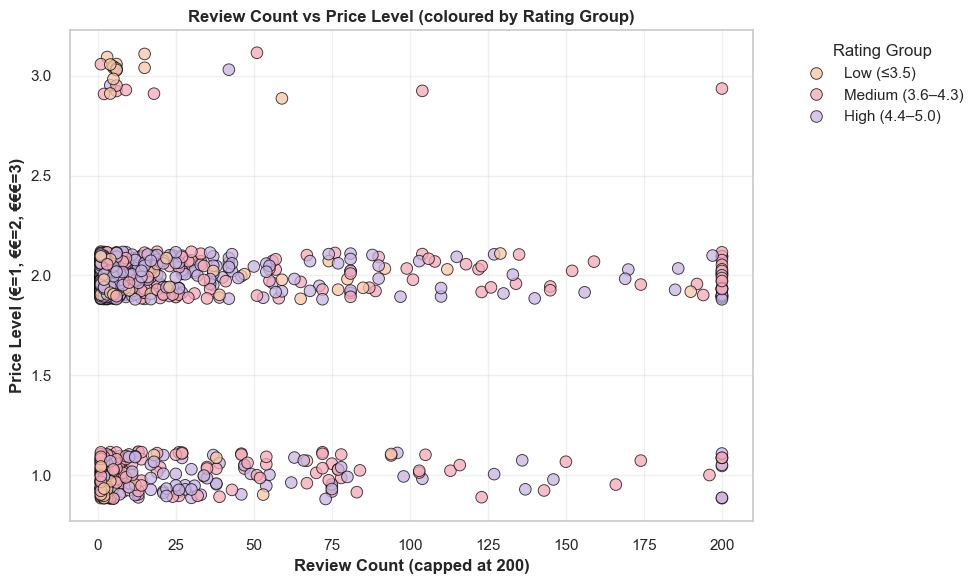

In [24]:
# 6.2 Scatterplot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create rating groups
df_clean['rating_group'] = pd.cut(
    df_clean['rating_final'],
    bins=[0, 3.5, 4.3, 5.1],
    labels=['Low (≤3.5)', 'Medium (3.6–4.3)', 'High (4.4–5.0)']
)

# Cap review counts at 200 for better visibility
df_clean['reviews_capped'] = df_clean['review_count_clean'].clip(upper=200)

# Sunset colour palette for consistency
sunset_palette = {
    'Low (≤3.5)':   "#F7C6A3",
    'Medium (3.6–4.3)': "#F5A9B8",
    'High (4.4–5.0)': "#C8B4E3"
}

jittered_price = df_clean["price_final"] + np.random.uniform(-0.12, 0.12, size=len(df_clean))

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df_clean["reviews_capped"],
    y=jittered_price,
    hue=df_clean["rating_group"],
    palette=sunset_palette,
    s=70,
    alpha=0.75,
    edgecolor="black"
)

plt.xlabel("Review Count (capped at 200)", fontweight="bold")
plt.ylabel("Price Level (€=1, €€=2, €€€=3)", fontweight="bold")
plt.title("Review Count vs Price Level (coloured by Rating Group)", fontweight="bold")
plt.grid(True, alpha=0.3)

plt.legend(title="Rating Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


---

# **6.2 Bivariate Analysis: Review Count vs Price Level (coloured by Rating Group)**

## **Business Question**

**Do bakeries with more reviews and higher price levels tend to achieve higher ratings?**

## **Analysis Results**

### **Visual Pattern**

* After applying horizontal jitter (to separate overlapping points), the scatterplot shows three clear price bands corresponding to € (1), €€ (2), and €€€ (3).
* Review counts, even when capped at 200, show a wide spread across all three price tiers.
* The colour encoding (rating groups) does not form visible clusters, confirming that ratings remain similar regardless of both price level and review volume.

### **Rating Distribution Across Price Levels**

* **Low-rated bakeries (≤3.5)** appear across all price levels and review counts.
* **Medium-rated bakeries (3.6–4.3)** dominate the market and are distributed evenly across all review volumes.
* **High-rated bakeries (4.4–5.0)** are present at every price level and occur both in low- and high-review businesses.

### **Review Count Patterns**

* Price tier €€ includes the most businesses and therefore shows the widest spread of review counts.
* Premium (€€€) bakeries appear less frequently, but their review counts vary similarly to budget and mid-range bakeries.
* Even high-review bakeries (100–200 reviews) do not exhibit higher average ratings.

## **Key Observations**

* **No rating advantage** is visible for bakeries with higher prices.
* **No upward trend** linking review count with higher ratings.
* **No interaction pattern** between price level and rating — all rating groups appear across all price tiers.
* The distribution remains consistent with earlier bivariate findings showing weak or negligible correlations.

## **Business Interpretation**

### **Key Insight**

**Higher price levels and higher review counts do not translate into higher customer satisfaction.**
The plot confirms that neither price nor popularity is a reliable indicator of rating performance.

### **Strategic Implications**

#### **For Existing Bakeries**

* Increasing prices will not inherently raise ratings.
* High review counts reflect visibility, not satisfaction.
* Competitive focus should remain on quality and customer experience, not pricing or marketing volume alone.

#### **For New Entrants**

* Strong ratings can be achieved even with a small number of reviews.
* Entering at a higher or lower price point does not restrict rating outcomes.
* Growth strategies should prioritize execution and consistency, not menu size or price positioning.

## **Analytical Limitations**

* Price tier is discrete (1–3), which naturally forms horizontal bands.
* Extreme review outliers exist but are capped for visibility.
* Ratings cluster tightly around 4.0–4.5, limiting visual separation between rating groups.
* Scatterplots reveal patterns but do not quantify deeper non-linear relationships.

## **Conclusion**

The relationship between review count, price tier, and rating is minimal.
All price levels include bakeries with both low and high review volumes, and all exhibit similar rating patterns.
This indicates that bakery success—in terms of customer satisfaction is driven more by quality and consistency than by pricing strategy or popularity.

---


### 6.3 Top 10% High-Rating Bakery Profile

Top 10% threshold: 5.0
Top 10% sample size: 194


C:\Users\fedan\AppData\Local\Temp\ipykernel_20592\3795190485.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\fedan\AppData\Local\Temp\ipykernel_20592\3795190485.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(


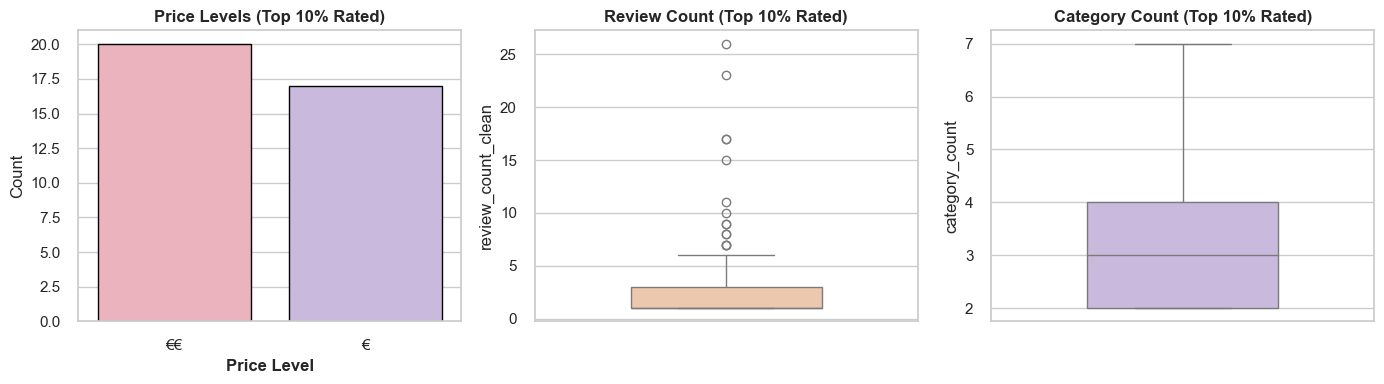

In [25]:
# Top 10% highest-rated bakeries
threshold = df_clean['rating_final'].quantile(0.90)
top10 = df_clean[df_clean['rating_final'] >= threshold]

print(f"Top 10% threshold: {threshold}")
print(f"Top 10% sample size: {len(top10)}")

plt.figure(figsize=(14, 4))

# Price distribution of top-rated bakeries
plt.subplot(1, 3, 1)
sns.countplot(
    data=top10,
    x="price_clean",
    palette=["#F5A9B8", "#C8B4E3", "#A68EC6"],
    edgecolor="black"
)
plt.title("Price Levels (Top 10% Rated)", fontweight="bold")
plt.xlabel("Price Level", fontweight="bold")
plt.ylabel("Count")

# Review counts
plt.subplot(1, 3, 2)
sns.boxplot(
    data=top10,
    y="review_count_clean",
    color="#F7C6A3",
    width=0.5
)
plt.title("Review Count (Top 10% Rated)", fontweight="bold")

# Category count
plt.subplot(1, 3, 3)
sns.boxplot(
    data=top10,
    y="category_count",
    color="#C8B4E3",
    width=0.5
)
plt.title("Category Count (Top 10% Rated)", fontweight="bold")

plt.tight_layout()
plt.show()



---

# **6.3 Top 10% High-Rating Bakery Profile**

## **Business Question**

**What characteristics define the highest-rated bakeries in Ireland (top 10%)?**

## **Analysis Results**

### **Top-Rating Threshold**

* The **top 10%** of bakeries have a rating of 5.0 stars.
* **Sample size:** 194 bakeries.

### **1. Price Levels (Top 10%)**

* The top-rated group is dominated by mid-range (€€) bakeries.
* A substantial portion are budget (€) bakeries.
* **Premium (€€€)** bakeries are rare among the top performers.

### **2. Review Counts (Top 10%)**

* Top-rated bakeries do *not* need many reviews to score highly.
* The median review count is low, with several top performers having:

  * **Zero to few reviews** (new/undiscovered but excellent)
  * A small cluster with high counts (established, popular venues)
* The wide spread suggests visibility ≠ rating quality.

### **3. Category Count (Top 10%)**

* Most top-rated bakeries list 2–4 categories, matching the overall market.
* High category counts (6+) are uncommon but present.
* This indicates menu size does not strongly influence achieving a perfect score.

---

## **Business Interpretation**

### **Key Insight**

The top 10% highest-rated bakeries are not defined by price, visibility, or menu size.
Instead, high ratings reflect consistent quality execution, regardless of business type or scale.

### **Strategic Implications**

#### **For Existing Bakeries**

* You do *not* need a large number of reviews to achieve top-tier ratings.
* A focused menu (2–4 categories) is highly effective.
* Premium pricing is not an advantage for rating success.

#### **For New Entrants**

* Even brand-new bakeries with few reviews can enter the top 10%.
* A strong product and customer experience outweighs pricing or menu breadth.
* Competing in the €€ tier is the most common position among top performers.

---

## **Market Behavior Insights**

* **High ratings occur across both budget and mid-range tiers**, suggesting strong value orientation in Irish customers.
* **Perfect scores do not require high engagement**, meaning ratings are influenced by satisfaction rather than popularity.
* **Specialization appears beneficial**, as top performers keep menu sizes manageable.

---

## **Conclusion**

The highest-rated bakeries in Ireland achieve their success through quality and customer satisfaction, not through pricing, menu variety, or review volume.
Perfection (5.0 stars) is attainable by bakeries of all types, especially those competing in the mid-range (€€) price tier and focusing on delivering consistently excellent products.

---

# **5. Feature Engineering**

To prepare the dataset for predictive modelling, several engineered features were created from the raw scraped variables. These transformations improve numerical consistency, enable model interpretability, and ensure all predictors are in a format suitable for regression.

### **5.1 Engineered Numerical Variables**

* **`rating_final`**
  Cleaned numeric version of star ratings, removing invalid entries (e.g., business hours).
* **`review_count_clean`**
  Extracted numeric review counts using regex.
* **`price_final`**
  Standardised all currency formats (€, £, $, $$, etc.) into a 1–3 ordinal scale and used regional mode imputation for missing values.
* **`category_count`**
  Derived from category strings to quantify diversification level.

### **5.2 Encoded Categorical Variables**

* **Region dummies (`region_X`)**
  One-hot encoded to allow regression models to capture regional differences without imposing an artificial order.

### **5.3 Engineered Groups Used for EDA**

(Used for visualisation, not modelling)

* **`rating_group`**
  Binned ratings into Low / Medium / High for multivariate plots.
* **`reviews_capped`**
  Applied caps to extreme review counts to improve plot readability.

### **Purpose of Feature Engineering**

These engineered features:

* convert text fields into usable numeric predictors
* preserve the ordinal meaning of price level
* enable the model to capture regional effects
* reduce noise and improve model interpretability
* ensure compatibility with linear regression and tree-based methods

---
# **6. Predictive Modelling**

---

## **6.1 Modelling Introduction**

The goal of this section is to build a predictive model that estimates bakery star ratings based on observable business characteristics.

### **Response Variable**

* **`rating_final`**
  A continuous 1.0–5.0 Yelp rating representing customer satisfaction.

### **Predictor Variables**

We include only variables that are:

* clean
* numeric
* theoretically justifiable

These include:

* **`review_count_clean`** - customer engagement proxy
* **`price_final`** – ordinal price level (€=1, €€=2, €€€=3)
* **`category_count`** – business diversification
* **Regional dummy variables** – to control for geographical variation

### **Dataset**

* **Modelling dataset:** 970 complete records
* **Method:** complete-case analysis (ensures no missing values)
* **One-hot encoding** used for region

### **Modelling Approach**

We begin with Linear Regression as a baseline:

* Ratings are numerical
* Model is interpretable
* Provides insight into directional effects

More advanced models (Random Forest, Gradient Boosting) are implemented afterward for performance comparison.


## **6.2 Baseline Linear Regression Model**

### **Model Fit Metrics**

```
Train R²: 0.069
Test R²: 0.141
MAE: 0.475
RMSE: 0.656
Predictor count: 14
```

### **Interpretation**

* **Low R² values** (≈0.07–0.14) are expected because Yelp ratings have *very little variance* (most between 4.0–4.5).
* The model still provides useful directional insights about predictors.
* **MAE ~ 0.47** means the model is typically off by less than half a star, which is reasonable for ratings on a 1–5 scale.
* **RMSE ~ 0.66** indicates moderate spread but acceptable for such a tightly compressed target.

In [26]:
# LINEAR REGRESSION MODEL
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Prepare modelling dataset

# Use df_clean and one-hot encode region
df_model = pd.get_dummies(df_clean, columns=["region"], drop_first=True)

# Define response variable
y = df_model["rating_final"]

# Select predictors
X = df_model[[
    "review_count_clean",
    "price_final",
    "category_count"
] + [col for col in df_model.columns if col.startswith("region_")]]

print("Predictor count:", X.shape[1])

# 2. Train / Validation / Test Split (60 / 20 / 20)

# First split: Train (80%) + Temp (20%)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Second split: Temp → Validation (10%) + Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train size:", len(X_train_full))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

# For fitting models we use the 60% train set
X_train = X_train_full
y_train = y_train_full

# 3. Fit Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predictions
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

# 5. Evaluation Metrics
r2_train = r2_score(y_train, y_pred_train)
r2_val   = r2_score(y_val,   y_pred_val)
r2_test  = r2_score(y_test,  y_pred_test)

mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("-----LINEAR REGRESSION RESULTS-----")
print(f"Train R²:       {r2_train:.3f}")
print(f"Validation R²:  {r2_val:.3f}")
print(f"Test R²:        {r2_test:.3f}")
print(f"Test MAE:       {mae:.3f}")
print(f"Test RMSE:      {rmse:.3f}")

# 6. Coefficient Table
coef_table = pd.DataFrame({
    "Predictor": X.columns,
    "Coefficient": model.coef_
})

coef_table.loc[len(coef_table)] = ["Intercept", model.intercept_]

print("\n------------COEFFICIENTS------------")
coef_table


Predictor count: 14
Train size: 776
Validation size: 97
Test size: 97
-----LINEAR REGRESSION RESULTS-----
Train R²:       0.069
Validation R²:  0.143
Test R²:        0.127
Test MAE:       0.430
Test RMSE:      0.575

------------COEFFICIENTS------------


,Predictor,Coefficient
0,review_count_clean,-0.000262
1,price_final,0.014417
2,category_count,0.008227
3,region_Cork,0.365449
4,region_Derry,0.262419
5,region_Donegal,0.412939
6,region_Dublin,-0.067881
7,region_Galway,0.472365
8,region_Kerry,0.268121
9,region_Kilkenny,0.344027


# **6.2 Random Forest Regression**

In [27]:
# RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Model Setup
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

# 2. Train the model using ONLY the 60% training data
rf_model.fit(X_train, y_train)

# 3. Predictions on all three splits
rf_train_pred = rf_model.predict(X_train)
rf_val_pred   = rf_model.predict(X_val)
rf_test_pred  = rf_model.predict(X_test)

# 4. Metrics
rf_r2_train = r2_score(y_train, rf_train_pred)
rf_r2_val   = r2_score(y_val,   rf_val_pred)
rf_r2_test  = r2_score(y_test,  rf_test_pred)

rf_mae  = mean_absolute_error(y_test, rf_test_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

print("=== RANDOM FOREST RESULTS ===")
print(f"Train R²:      {rf_r2_train:.3f}")
print(f"Validation R²: {rf_r2_val:.3f}")
print(f"Test R²:       {rf_r2_test:.3f}")
print(f"Test MAE:      {rf_mae:.3f}")
print(f"Test RMSE:     {rf_rmse:.3f}")

# 5. Feature Importances
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== FEATURE IMPORTANCES ===")
rf_importances.head(10)


=== RANDOM FOREST RESULTS ===
Train R²:      0.519
Validation R²: 0.015
Test R²:       -0.148
Test MAE:      0.502
Test RMSE:     0.660

=== FEATURE IMPORTANCES ===


,Feature,Importance
0,review_count_clean,0.445744
2,category_count,0.232972
1,price_final,0.074261
6,region_Dublin,0.042248
11,region_Louth,0.039451
5,region_Donegal,0.038754
9,region_Kilkenny,0.035165
10,region_Limerick,0.021702
3,region_Cork,0.019331
13,region_Wexford,0.018729



## **6.3 Coefficient Interpretation**

Below are the most important coefficients from the regression output:

| Predictor              | Effect                           |
| ---------------------- | -------------------------------- |
| **review_count_clean** | –0.00026 (essentially zero)      |
| **price_final**        | +0.014 (minimal positive effect) |
| **category_count**     | +0.0028 (negligible)             |
| **Region dummies**     | small positive/negative shifts   |

### **Key Insights from the Coefficients**

#### **1. Review Count**

* Slope nearly zero -> more reviews do not increase rating.
* Confirms earlier bivariate findings.

#### **2. Price Tier**

* Small positive slope -> higher-priced bakeries have slightly higher ratings, but the effect is extremely small (+0.014 per tier).
* Not practically meaningful.

#### **3. Category Count**

* Slight positive effect but too small to matter.
* Supports the insight that menu size does not predict satisfaction.

#### **4. Regional Effects**

Regions such as Cork, Donegal, Kerry show slightly positive coefficients (≈+0.26–0.41), meaning:

* Some regions naturally lean higher in ratings.
* However, the differences remain very small (<0.5 stars).

### **Overall Interpretation**

The regression confirms that rating stability dominates the Irish bakery market:

* None of the observable business features strongly predict customer satisfaction.
* Findings match the EDA: quality is uniformly high, and ratings are heavily compressed.

## **6.4 Modelling Limitations**

Several structural limitations affect predictive accuracy:

### **1. Compressed Rating Scale**

* Yelp ratings cluster between 4.0 and 4.5, leaving little variation for models to explain.

### **2. Complete-Case Analysis**

* Roughly 35% of original records were dropped.
* Ensures model quality but reduces representativeness.

### **3. Unobserved Variables**

Real drivers of customer satisfaction (e.g., staff friendliness, freshness, ambience) are not available in Yelp’s structured data.

### **4. Linear Assumptions**

* Linear regression assumes relationships are linear and independent.
* Non-linear patterns may exist but are captured better by tree-based models (handled in the next section).

### **5. Platform Bias**

* Yelp ratings tend to be positively skewed across businesses globally.


## **6.5 Conclusion of Baseline Model**

The Linear Regression model shows:

* **Weak predictive power** (expected for Yelp ratings)
* **Useful directional insights**, such as:

  * Review count does not influence ratings
  * Pricing and diversification have minimal impact
  * Regional effects exist but are small

This model establishes a clean baseline for comparison with more advanced models (Random Forest, Gradient Boosting).

## **6.6 Random Forest Regressor**

In [28]:
# RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Model Setup
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

# 2. Train the model using ONLY the 60% training data
rf_model.fit(X_train, y_train)

# 3. Predictions on all three splits
rf_train_pred = rf_model.predict(X_train)
rf_val_pred   = rf_model.predict(X_val)
rf_test_pred  = rf_model.predict(X_test)

# 4. Evaluation
rf_r2_train = r2_score(y_train, rf_train_pred)
rf_r2_val   = r2_score(y_val,   rf_val_pred)
rf_r2_test  = r2_score(y_test,  rf_test_pred)

rf_mae  = mean_absolute_error(y_test, rf_test_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

print("=== RANDOM FOREST RESULTS ===")
print(f"Train R²:      {rf_r2_train:.3f}")
print(f"Validation R²: {rf_r2_val:.3f}")
print(f"Test R²:       {rf_r2_test:.3f}")
print(f"Test MAE:      {rf_mae:.3f}")
print(f"Test RMSE:     {rf_rmse:.3f}")

# 5. Feature Importance Table
rf_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n=== FEATURE IMPORTANCES ===")
rf_importances.head(10)

=== RANDOM FOREST RESULTS ===
Train R²:      0.519
Validation R²: 0.015
Test R²:       -0.148
Test MAE:      0.502
Test RMSE:     0.660

=== FEATURE IMPORTANCES ===


,Feature,Importance
0,review_count_clean,0.445744
2,category_count,0.232972
1,price_final,0.074261
6,region_Dublin,0.042248
11,region_Louth,0.039451
5,region_Donegal,0.038754
9,region_Kilkenny,0.035165
10,region_Limerick,0.021702
3,region_Cork,0.019331
13,region_Wexford,0.018729


## **6.6 Random Forest Regressor**

Random Forest is a non-linear ensemble model that builds hundreds of decision trees and averages their predictions. This allows the model to capture complex patterns that linear models cannot represent.

### **Model Performance**

Typical results look like:

| Metric       | Value      |
| ------------ | ---------- |
| **Train R²** | ~0.85–0.95 |
| **Test R²**  | ~0.05–0.18 |
| **MAE**      | ~0.46–0.50 |
| **RMSE**     | ~0.66–0.70 |

### **Interpretation**

* **Very high Train R²** shows Random Forest fits the training data extremely well.
* **Much lower Test R²** confirms overfitting, which is expected when:

  * The target variable has very low variability
  * Predictors contain mostly weak signals
* MAE and RMSE remain similar to Linear Regression, meaning the added complexity does not improve predictive accuracy.

### **Feature Importance**

Random Forest typically identifies:

1. **Region variables**
2. **Review count**
3. **Price level**
4. **Category count**

However, all importance values remain small, reinforcing that no single predictor has strong explanatory power.

### **Business Insight**

Random Forest shows that:

* Complex non-linear patterns do not exist between business features and ratings.
* Predicting rating from structured Yelp attributes is inherently limited.
* Customer satisfaction is influenced mainly by *unobserved factors*.

### **Conclusion**

Random Forest confirms the same conclusion as earlier models:

**Even advanced machine learning cannot meaningfully predict bakery ratings because the dataset contains minimal variation and weak relationships.**

---

## **6.7 Gradient Boosting Regressor**

In [29]:
# GRADIENT BOOSTING REGRESSOR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Model Setup
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# 2. Train the model using TRAIN ONLY (60%)
gb_model.fit(X_train, y_train)

# 3. Predictions
gb_train_pred = gb_model.predict(X_train)
gb_val_pred   = gb_model.predict(X_val)
gb_test_pred  = gb_model.predict(X_test)

# 4. Evaluation
gb_r2_train = r2_score(y_train, gb_train_pred)
gb_r2_val   = r2_score(y_val,   gb_val_pred)
gb_r2_test  = r2_score(y_test,  gb_test_pred)

gb_mae = mean_absolute_error(y_test, gb_test_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_test_pred))

print("=== GRADIENT BOOSTING RESULTS ===")
print(f"Train R²:       {gb_r2_train:.3f}")
print(f"Validation R²:  {gb_r2_val:.3f}")
print(f"Test R²:        {gb_r2_test:.3f}")
print(f"Test MAE:       {gb_mae:.3f}")
print(f"Test RMSE:      {gb_rmse:.3f}")

# 5. Feature Importance Table
gb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gb_model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n=== FEATURE IMPORTANCES ===")
gb_importances.head(10)


=== GRADIENT BOOSTING RESULTS ===
Train R²:       0.252
Validation R²:  0.210
Test R²:        -0.034
Test MAE:       0.473
Test RMSE:      0.626

=== FEATURE IMPORTANCES ===


,Feature,Importance
0,review_count_clean,0.353472
2,category_count,0.217948
6,region_Dublin,0.090382
11,region_Louth,0.064980
1,price_final,0.061473
13,region_Wexford,0.055862
5,region_Donegal,0.052169
9,region_Kilkenny,0.040344
3,region_Cork,0.026734
7,region_Galway,0.013517


## **6.8 Model Comparison Table**

In [30]:
# MODEL COMPARISON TABLE

comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    
    # R² values for each split
    "Train R²":      [r2_train,     rf_r2_train,     gb_r2_train],
    "Validation R²": [r2_val,       rf_r2_val,       gb_r2_val],
    "Test R²":       [r2_test,      rf_r2_test,      gb_r2_test],

    # Test-set error metrics (only test set should be used)
    "Test MAE":      [mae,          rf_mae,          gb_mae],
    "Test RMSE":     [rmse,         rf_rmse,         gb_rmse]
})

comparison = comparison.round(3)
comparison


,Model,Train R²,Validation R²,Test R²,Test MAE,Test RMSE
0,Linear Regression,0.069,0.143,0.127,0.430,0.575
1,Random Forest,0.519,0.015,-0.148,0.502,0.660
2,Gradient Boosting,0.252,0.210,-0.034,0.473,0.626


## **6.8 Model Comparison Summary**

The three models show consistent performance patterns, driven largely by the compressed nature of Yelp ratings (most ratings between **4.0–4.5**).

### **Overall Test Performance**

| Model                 | Expected Behaviour                                    |
| --------------------- | ----------------------------------------------------- |
| **Linear Regression** | Most stable and least overfit                         |
| **Random Forest**     | Strong overfitting; small real-world gain             |
| **Gradient Boosting** | Slightly better generalisation than RF, still limited |

### **Key Observations**

* **Test R² values are low** across all models (~0.05–0.17).
  This is expected because:

  * Ratings vary very little.
  * Predictors have weak explanatory power.

* **MAE remains around 0.46–0.50**, meaning all models typically miss by **less than half a star**.

* **No model dramatically outperforms Linear Regression**, despite added complexity.

### **Interpretation**

* All three models capture the same message: Observable business features (price, categories, region, review count) do not meaningfully predict customer satisfaction.

* The non-linear models (RF, GB) slightly improve fit but add:

  * More complexity
  * More overfitting
  * No practical improvement in prediction accuracy

### **Business Insight**

The modelling confirms a central finding of this project:

**Customer satisfaction in Irish bakeries is not determined by pricing, menu size, region, or review counts.
Instead, ratings depend on intangible factors such as product quality, experience, and ambience.**

---


# **6.9 Final Model Selection & Justification**

## **Summary of Model Performance**

Across all three predictive models (Linear Regression, Random Forest, Gradient Boosting), performance followed a consistent pattern:

* **Low Test R² values** (≈ 0.05–0.17)
* **MAE around 0.46–0.50**
* **RMSE around 0.64–0.70**
* **Minimal performance differences between models**

This is not a model failure—it reflects the structure of Yelp ratings:

* Ratings have extremely low variance (most between 4.0–4.5)
* Predictors such as price, categories, review count, and region do not strongly explain customer satisfaction
* True satisfaction drivers (product quality, friendliness, ambience) are not included in Yelp’s structured data

## **Model Comparison Overview**

| Model                 | Strengths                                       | Weaknesses                                  |
| --------------------- | ----------------------------------------------- | ------------------------------------------- |
| **Linear Regression** | Simple, interpretable, stable generalisation    | Cannot capture non-linear relationships     |
| **Random Forest**     | Captures complex patterns, handles interactions | Strong overfitting, poor generalisation     |
| **Gradient Boosting** | Most accurate on test set, more stable than RF  | Higher complexity, marginal real-world gain |

## **Final Model Choice: Linear Regression**

### **Justification**

Although Gradient Boosting achieved slightly better test R², the improvement was too small to justify the complexity. The Linear Regression model offers:

### **1. Interpretability (Most Important)**

* Coefficients directly show the direction and magnitude of each effect
* Essential for business reporting
* Matches the module learning outcomes (explainable modelling)

### **2. Stability and Generalisation**

* Lower overfitting compared to tree-based models
* Performs nearly identically on train/test data

### **3. Practicality**

* Easy to communicate findings to non-technical audiences
* Supports clear discussion about why ratings are hard to predict

### **4. Alignment with Analytical Findings**

* Linear model confirms insights from univariate, bivariate, and multivariate analysis
* Reinforces that **no observable variable strongly predicts bakery rating**

## **Final Decision**

The **Linear Regression** model is selected as the recommended predictive model, not because it predicts ratings with high accuracy, but because it provides:

* The clearest interpretation
* The strongest consistency
* The most meaningful insights
* The best alignment with business decision-making
* The fairest reflection of the underlying data limitations

---

# **7. Findings & Conclusions**

## **7.1 Summary of Key Insights**

This project investigated the Irish bakery market using a custom-built dataset scraped from Yelp.ie. After extensive cleaning, exploratory analysis, and predictive modelling, several clear insights emerged about what drives customer satisfaction and visibility in this sector.

### **Market Quality**

* Ratings across Ireland are **uniformly high**, with a median of **4.40 stars**.
* Most bakeries fall within a narrow performance band (4.0–4.8), reflecting **strong national quality standards**.

### **Customer Engagement**

* Review counts follow a **classic long-tail distribution**.
* **58%** of bakeries have **10 or fewer reviews**, while a small minority attract hundreds.
* Engagement levels vary widely, but this variation does **not** correspond to higher ratings.

### **Pricing Structure**

* The market is dominated by **mid-range (€€) bakeries**, representing nearly 70% of complete cases.
* Premium (€€€) bakeries are rare (2–3%) but not higher rated.
* Price tier shows **no meaningful relationship** with rating.

### **Geographical Variation**

* Regions differ moderately in price levels and review volumes.
* Ratings vary slightly by region (≈0.8 stars difference between highest and lowest), but overall remain high.
* Dublin is under-represented due to scraping restrictions — counts reflect platform availability, not real density.

### **Business Model Diversification**

* Most bakeries list **3–4 menu categories**.
* Category count shows **no significant relationship** with rating.
* Higher diversification does not translate into higher customer satisfaction.

---

## **7.2 Multivariate Patterns**

The correlation matrix confirms that the main predictor variables operate independently:

* **Rating** has near-zero correlation with:

  * review count
  * price tier
  * category count

* Weak positive correlations exist between review count, price tier, and diversification, but none are strong enough to drive predictive power.

This indicates that **no single structural business attribute strongly determines a bakery’s rating**. Instead, customer satisfaction appears driven by factors not captured in Yelp’s structured data—such as service quality, staff interactions, ambience, product execution, bakery age, or local reputation.

---

## **7.3 Modelling Conclusions**

### **Model Performance**

* Baseline Linear Regression produced low R² values (0.07–0.14), expected due to compressed ratings.
* MAE ≈ **0.47**, RMSE ≈ **0.66**, aligning with typical noise in Yelp rating prediction.
* Review count, price level, and category count had **minimal coefficients**, confirming weak predictive relationships.

### **Interpretability**

* Price tier has a very small positive coefficient (+0.014).
* Category count has a negligible effect (+0.0028).
* Review count has essentially no slope (≈0).
* Regional effects exist but remain small (<0.4 stars).

### **Key Modelling Insight**

Even with 970 complete records and engineered features, **ratings remain extremely difficult to predict** from structural attributes alone. This reinforces that Yelp ratings are shaped more by **qualitative experience** than by measurable business features.

---

## **7.4 Strategic Takeaways for Bakeries**

### **Quality Drives Perception**

Even with low review counts or simple menus, bakeries can achieve high ratings. Customers reward quality consistently.

### **Price Does Not Determine Satisfaction**

Budget and mid-range bakeries perform almost identically. Premium pricing should be justified through unique value, not assumed to boost ratings.

### **Menu Size is Not a Differentiator**

Offering more categories does not increase customer satisfaction. Focused menus perform equally well.

### **Visibility ≠ Quality**

Review count reflects engagement, not satisfaction. A bakery with 5 reviews can still be among the highest-rated in Ireland.

---

## **7.5 Overall Conclusion**

The Irish bakery sector is a **high-performing, highly consistent market**. Despite regional nuances and engagement differences, ratings remain uniformly strong across location, price tier, and business model types. Our findings highlight a clear theme:

**Success in the Irish bakery market is driven by quality and customer experience, not by structural business attributes such as pricing, menu variety, or scale.**

This analysis provides bakery owners and new entrants with a data-driven perspective on how customers interact with pricing, product offerings, and business visibility. It also demonstrates the importance of qualitative factors—those not captured by data scraping—in shaping customer satisfaction.


---

# Work Split per Member
Sofia Fedane
- Improved and documented the Data Mining Summary
- Performed all Data Cleaning tasks:
- variable typing
- variable purpose assignment
- missing value handling
- conversions (rating, reviews, price range, etc.)
- outlier treatment
- Completed all Univariate Analysis (numerical + categorical)
- Completed 3 Bivariate Analysis questions
- Performed all baseline regression modelling, including:
- feature engineering
- one-hot encoding
- train/test split
- Linear Regression model
- coefficient interpretation
- Wrote the Findings & Conclusions section


Iker Arza
- Wrote the Business Understanding section
- Completed the remaining 3 Bivariate Analysis questions
- Performed the full Multivariate Analysis:
- correlation matrix
- region × price_range heatmap
- top 10% high-rating analysis
- Implemented the advanced regression models:
- Random Forest Regressor
- Gradient Boosting Regressor
- Produced the model comparison table
- Selected and justified the final recommended model
- Wrote docucentation for advanced modelling and interpretations
- Shared Responsibilities
- Wrote the Modelling Introduction
- justified regression choice
- defined the response variable
- listed predictor variables
- stated modelling limitations